In [1]:
import os
import sys
p = '..'
while not os.path.isdir(p + '/notebooks'):
    p += '/..'
sys.path.append(p) # for import src

import os
import cloudpickle
import lzma
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_predict
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import lightgbm as lgb
import talib
import joblib

import src
from src.ml_utils import (
    fetch_ohlcv, 
    visualize_result, 
    normalize_position, 
    calc_position_cv2,
    get_feature_columns,
    get_symbols,
    unbiased_rank,
    ewm_finite,
)
from src.data_fetcher import DataFetcher
cloudpickle.register_pickle_by_value(src) # for model portability

os.environ["USE_JOBLIB_MEMORY"] = "1"

def get_joblib_memory():
    if os.getenv('USE_JOBLIB_MEMORY'):
        return joblib.Memory('/tmp/alphapool_joblib_memory', verbose=0)
    else:
        return joblib.Memory(None, verbose=0)

model_name = '20221028_btc_one_cnn_h8'

In [2]:
# symbols = os.getenv('ALPHAPOOL_SYMBOLS').split(',') # 売買代金が多く、古いもの
# symbols += 'DOGE,SFP,DYDX,AXS,CHZ,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
# symbols += 'SFP,DYDX,AXS,TRX,MASK,ETC,LTC,1000SHIB,C98,SAND,SUSHI,NEAR,FIL'.split(',')
symbols = ['ADA', 'ATOM', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC'] # binance, bybit, okex
# symbols = ['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP', 'ETC', 'LTC'] # binance, bybit
# symbols = ['ADA', 'ATOM', 'BNB', 'BTC', 'DOT', 'ETH', 'LINK', 'MATIC', 'XRP'] # binance, bybit

provider_configs = [
    {
        'provider': 'bigquery',
        'options': {
            'table': 'binance_ohlcv',
            'symbols': ['{}USDT'.format(x) for x in symbols],
        }
    },
]

dfs = DataFetcher(memory=get_joblib_memory()).fetch(
    provider_configs=provider_configs, 
    min_timestamp=None,
)

for df in dfs:
    display(df)

def merge_data(dfs):
    df = dfs[0]
    df['symbol'] = df['symbol'].str.replace('USDT', '')
    df = df.set_index(['timestamp', 'symbol']).sort_index()
    return df

df = merge_data(dfs)

def merge_kraken_data(df):
    symbols = list(df.index.get_level_values('symbol').unique())
    
    train_provider_configs = [
        {
            'provider': 'bigquery',
            'options': {
                'table': 'kraken_historical_ohlcvt',
                'symbols': symbols,
            }
        },
    ]

    dfs = DataFetcher(memory=get_joblib_memory()).fetch(
        provider_configs=train_provider_configs, 
        min_timestamp=None,
    )
    df_kraken = dfs[0].set_index(['timestamp', 'symbol'])

    df = df.copy()
    df['extended'] = False
    df = pd.concat([df, df_kraken])
    df['extended'] = df['extended'].fillna(True)
    df = df[['op', 'hi', 'lo', 'cl', 'volume', 'twap_5m', 'extended']]
    df = df.loc[~df.index.duplicated()]
    df = df.sort_index()
    return df.copy()

df = merge_kraken_data(df)

df = df.dropna()
df.to_pickle('/tmp/df_binance_ohlcv_extended.pkl')
display(df)

,timestamp,symbol,op,hi,lo,cl,volume,amount,trades,buy_volume,...,twap,twap_5m,cl_std,cl_diff_std,hi_twap,lo_twap,hi_op_max,lo_op_min,ln_hi_lo_mean,ln_hi_lo_sqr_mean
0,2021-07-07 11:00:00+00:00,ADAUSDT,1.4206,1.4330,1.4170,1.4300,14548171.0,2.077201e+07,43515.0,7770863.0,...,1.427578,1.428275,0.003467,0.001119,1.428347,1.426760,0.000923,-0.000663,0.001112,0.000002
1,2021-06-20 11:00:00+00:00,ADAUSDT,1.3476,1.3533,1.3260,1.3293,38181143.0,5.110403e+07,87818.0,18535250.0,...,1.338757,1.337625,0.006228,0.003071,1.341067,1.336997,0.001983,-0.002087,0.003039,0.000011
2,2021-06-19 23:00:00+00:00,ADAUSDT,1.3910,1.4018,1.3821,1.3829,15747336.0,2.191540e+07,54828.0,7464234.0,...,1.391135,1.391458,0.004761,0.001728,1.392305,1.390117,0.001062,-0.001127,0.001573,0.000003
3,2021-06-25 09:00:00+00:00,ADAUSDT,1.3398,1.3570,1.3230,1.3289,37778606.0,5.060536e+07,79282.0,19752438.0,...,1.340072,1.341042,0.009537,0.002410,1.342172,1.338507,0.001910,-0.001755,0.002736,0.000009
4,2021-06-11 12:00:00+00:00,ADAUSDT,1.5176,1.5199,1.5039,1.5108,16425309.0,2.482271e+07,61590.0,7741869.0,...,1.511205,1.511150,0.002715,0.001816,1.512712,1.510028,0.001377,-0.001307,0.001776,0.000003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241655,2022-01-06 01:00:00+00:00,MATICUSDT,2.2040,2.2090,2.1450,2.1658,13881959.0,3.026007e+07,48277.0,6040660.0,...,2.183553,2.182717,0.012705,0.004017,2.186607,2.180752,0.002413,-0.003441,0.002683,0.000008
241656,2022-01-02 22:00:00+00:00,MATICUSDT,2.5123,2.5345,2.5113,2.5303,4489515.0,1.133739e+07,23375.0,2343854.0,...,2.526055,2.526575,0.004697,0.001549,2.526978,2.524592,0.001218,-0.001168,0.000945,0.000001
241657,2022-01-06 22:00:00+00:00,MATICUSDT,2.2289,2.2671,2.2195,2.2666,6409873.0,1.435081e+07,28441.0,3350752.0,...,2.240022,2.240467,0.010433,0.003247,2.241735,2.237627,0.002330,-0.001778,0.001836,0.000004
241658,2022-01-08 03:00:00+00:00,MATICUSDT,2.0915,2.0991,2.0716,2.0905,6062434.0,1.264769e+07,25121.0,2769257.0,...,2.087220,2.087917,0.005760,0.002397,2.089287,2.085470,0.002032,-0.001785,0.001829,0.000004


op          hi         lo  \
timestamp                 symbol                                      
2013-10-06 21:00:00+00:00 BTC      122.00000   122.00000   122.0000   
2013-10-07 20:00:00+00:00 BTC      123.61000   123.61000   123.6100   
2013-10-08 02:00:00+00:00 BTC      123.91000   123.91000   123.9000   
2013-10-08 05:00:00+00:00 BTC      124.19000   124.19000   124.1800   
2013-10-09 09:00:00+00:00 BTC      124.01687   124.01687   123.8400   
...                                      ...         ...        ...   
2022-11-22 06:00:00+00:00 ETH     1098.57000  1100.04000  1083.0100   
                          LINK       5.99100     6.01000     5.8390   
                          LTC       61.92000    62.27000    61.5100   
                          MATIC      0.79510     0.79680     0.7803   
                          XRP        0.35400     0.35550     0.3509   

                                         cl        volume      twap_5m  \
timestamp                 symbol                                         
2013-10-06 21:00:00+00:00 BTC      122.0000  1.000000e-01   122.000000   
2013-10-07 20:00:00+00:00 BTC      123.6100  1.000000e-01   123.610000   
2013-10-08 02:00:00+00:00 BTC      123.9000  1.991600e+00   123.900000   
2013-10-08 05:00:00+00:00 BTC      124.1800  2.000000e+00   124.180000   
2013-10-09 09:00:00+00:00 BTC      123.8400  2.823000e+00   123.840000   
...                                     ...           ...          ...   
2022-11-22 06:00:00+00:00 ETH     1084.8200  4.174374e+05  1092.853333   
                          LINK       5.8760  5.164573e+06     5.932417   
                          LTC       61.6600  3.594963e+05    61.800000   
                          MATIC      0.7830  3.529054e+07     0.789225   
                          XRP        0.3534  9.421572e+07     0.353442   

                                  extended  
timestamp                 symbol            
2013-10-06 21:00:00+00:00 BTC         True  
2013-10-07 20:00:00+00:00 BTC         True  
2013-10-08 02:00:00+00:00 BTC         True  
2013-10-08 05:00:00+00:00 BTC         True  
2013-10-09 09:00:00+00:00 BTC         True  
...                                    ...  
2022-11-22 06:00:00+00:00 ETH        False  
                          LINK       False  
                          LTC        False  
                          MATIC      False  
                          XRP        False  

[420995 rows x 7 columns]

In [3]:
# based on 20220910_eda

import numba
from pandas.api.types import is_float_dtype

def signed_rsi_sma(x, timeperiod=14):
    v = x.diff(1).fillna(0)
    return (v.rolling(timeperiod, 1).sum() / (1e-37 + v.abs().rolling(timeperiod, 1).sum())).clip(-1, 1)

def uniform_rank(x):
    return unbiased_rank(x)
    # count = x.transform("count")
    # rank = x.rank()
    # return (rank - 0.5) / count

def beta_mean(df, col):
    # broadcast btc value
    idx = df.index.to_frame()
    idx['symbol'] = 'BTC'
    idx = pd.MultiIndex.from_frame(idx)
    return pd.Series(df.loc[idx, col].values, index=df.index)
    
def calc_features(df, with_ret=False):
    mem = get_joblib_memory()
    return mem.cache(do_calc_features)(df, with_ret=with_ret)
    
def do_calc_features(df, with_ret=False):
    dfs = []
    for symbol, df_symbol in df.groupby('symbol'):
        dfs.append(calc_features_single(df_symbol))
    df = pd.concat(dfs).sort_index()

    beta_window = 24 * 30
    # beta_window = 24 * 7

    # df['ln_cl_diff_mean'] = df.groupby('timestamp')['ln_cl_diff'].transform('mean')
    df['ln_cl_diff_mean'] = beta_mean(df, 'ln_cl_diff')
    
    # wrong
    # df['beta'] = df.groupby('symbol')['ln_cl_diff'].transform(lambda x: x.rolling(beta_window, 1).corr(df.loc[x.index, 'ln_cl_diff_mean'])).fillna(0).clip(0.1, 2.0)

    # df['beta'] = (
    #     (df['ln_cl_diff'] * df['ln_cl_diff_mean']).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    #     / (df['ln_cl_diff_mean'] ** 2).groupby('symbol').transform(lambda x: x.rolling(beta_window, 1).mean())
    # ).fillna(0).clip(0.1, 2.0)
    df['beta'] = 1.0
    
    dfs = [
        df,
        # df.drop(columns=get_feature_columns(df)),
    ]
    
    if with_ret:
        ret_mean = beta_mean(df, 'ret')
        dfs += [
            (uniform_rank(df.groupby('timestamp')['ret']) - 0.5).rename('ret_rank'),
            (df['ret'] - df['beta'] * ret_mean).rename('ret_beta'),
        ]
    
    for col in get_feature_columns(df):
        feature_mean = beta_mean(df, col)
        dfs += [
            # (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col + '_symbolrank'),
            (df[col] - df['beta'] * feature_mean).rename(col + '_symbolbeta'),
        ]
    df = pd.concat(dfs, axis=1)
    
    # dfs = [df]
    # for col in get_feature_columns(df):
    #     if '_symbolbeta' not in col:
    #         continue
    #     dfs += [
    #         (2 * uniform_rank(df.groupby('timestamp')[col]) - 1).rename(col.replace('symbolbeta', 'symbolbtrk')),
    #     ]
    # df = pd.concat(dfs, axis=1)
    
    df = df[sorted([x for x in df.columns if is_float_dtype(df.dtypes[x])])].copy().astype('float32')

    return df

def calc_features_single(df):
    df = df.copy()

    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    df['ln_cl'] = np.log(df['cl'])
    df['ln_hi'] = np.log(df['hi'])
    df['ln_lo'] = np.log(df['lo'])
    df['ln_hilo'] = 0.5 * (df['ln_hi'] + df['ln_lo'])
    df['ln_cl_diff'] = df['ln_cl'].diff(1).fillna(0)
    df['ln_volume'] = np.log1p(df['volume'])

    dfs = [df]
    
    # for i in range(1, 96):
    # for i in range(1, 96 // 4):
    for i in range(1, 96 // 8):
    # for i in range(1, 192 // 8):
        dfs += [
            # (df['ln_cl'] - df['ln_cl'].rolling(8 * i).mean()).fillna(0).rename('feature_{:02}_ln_cl_kairi'.format(i)), # good
            # df['ln_cl'].diff(8).shift(i * 8).fillna(0).rename('feature_ln_cl_diff_{:02}'.format(i)),
            df['ln_cl'].diff(8 * i).fillna(0).rename('feature_{:02}_ln_cl_diff'.format(i)), # good
            # df['ln_cl'].diff(1 * i).fillna(0).rename('feature_{:02}_ln_cl_diff'.format(i)),
            # df['ln_cl'].diff(4 * i).fillna(0).rename('feature_{:02}_ln_cl_diff'.format(i)),
            # df['ln_cl'].rolling(8 * i).std().fillna(0).rename('feature_{:02}_ln_cl_std'.format(i)),
            # df['ln_volume'].diff(8 * i).fillna(0).rename('feature_{:02}_ln_volume_diff'.format(i)),
            # df['ln_volume'].rolling(8 * i).mean().fillna(0).rename('feature_{:02}_ln_volume_mean'.format(i)),
            # np.log1p(df['volume'].rolling(8 * i).mean()).fillna(0).rename('feature_{:02}_ln_volume_mean2'.format(i)),
            # signed_rsi_sma(df['cl'], timeperiod=i).fillna(0).rename('feature_{:02}_rsi'.format(i)),
        ]

    return pd.concat(dfs, axis=1)

In [4]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input, Dense, Dropout, Reshape, Conv1D, Conv2D, Conv3D, Flatten, MaxPooling1D, AveragePooling1D,
    BatchNormalization, Concatenate, Activation, Rescaling, Add, Subtract, Lambda,
    GlobalMaxPooling1D, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam, SGD, Adam
from tensorflow.keras import regularizers
from tensorflow.keras import initializers
from scipy.stats import norm
from scikeras.wrappers import KerasRegressor
from functools import partial
import tensorflow_addons as tfa

2022-11-22 07:19:47.259495: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-22 07:19:47.433692: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-22 07:19:47.433752: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-22 07:19:47.465062: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-22 07:19:48.319853: W tensorflow/stream_executor/platform/de

In [5]:
from tensorflow.python.ops import gen_math_ops, nn_ops

class GaussianDropConnectDense(Dense):
    def build(self, input_shape):
        super().build(input_shape)
        
        self.kernel_initial = self.kernel.numpy()
        # print(self.kernel_initial)
        
#         self.kernel_old = self.kernel
#         self.bias_old = self.bias
        
        
        
#         self.kernel = self.kernel_old
#         self.bias = self.bias_old * tf.keras.backend.random_normal(
#             shape=tf.shape(self.bias_old),
#             mean=1.0,
#             stddev=sigma,
#             dtype=self.bias_old.dtype,
#             seed=None
#         )
    
    def call(self, inputs, training=None):     
        # dropout_rate = 0.3   
        dropout_rate = 0.5      
        # dropout_rate = 0.7
        sigma = np.sqrt(dropout_rate / (1.0 - dropout_rate))
        
        # kernel = self.kernel_initial + tf.keras.backend.dropout(self.kernel - self.kernel_initial, dropout_rate, seed=None) / (1.0 - dropout_rate)
        kernel = self.kernel_initial + (self.kernel - self.kernel_initial) * tf.keras.backend.random_normal(
            shape=tf.shape(self.kernel),
            mean=1.0,
            stddev=sigma,
            dtype=self.kernel.dtype,
            seed=None
        )
        bias = self.bias
        
        # kernel = self.kernel * tf.keras.backend.random_normal(
        #     shape=tf.shape(self.kernel),
        #     mean=1.0,
        #     stddev=sigma,
        #     dtype=self.kernel.dtype,
        #     seed=None
        # )
        # bias = self.bias * tf.keras.backend.random_normal(
        #     shape=tf.shape(self.bias),
        #     mean=1.0,
        #     stddev=sigma,
        #     dtype=self.bias.dtype,
        #     seed=None
        # )
        
        kernel = tf.keras.backend.in_train_phase(kernel, self.kernel, training=training)
        bias = tf.keras.backend.in_train_phase(bias, self.bias, training=training)
        
        if inputs.dtype.base_dtype != self._compute_dtype_object.base_dtype:
          inputs = math_ops.cast(inputs, dtype=self._compute_dtype_object)

        rank = inputs.shape.rank
        if rank == 2 or rank is None:
            outputs = gen_math_ops.MatMul(a=inputs, b=kernel)
        # Broadcast kernel to inputs.
        else:
          outputs = standard_ops.tensordot(inputs, kernel, [[rank - 1], [0]])
          # Reshape the output back to the original ndim of the input.
          if not context.executing_eagerly():
            shape = inputs.shape.as_list()
            output_shape = shape[:-1] + [kernel.shape[-1]]
            outputs.set_shape(output_shape)

        if self.use_bias:
          outputs = nn_ops.bias_add(outputs, bias)

        if self.activation is not None:
          outputs = self.activation(outputs)
        return outputs

In [6]:
class WeightLenCallback(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.initial_weights = self.model.get_weights()
        self.initial_weights_norm = self._calc_dist(self.initial_weights)
        self.prev_weights = self.initial_weights
        self.weight_len = 0.0

    def on_epoch_end(self, epoch, logs=None):
        weights = self.model.get_weights()
        weight_dist = self._calc_dist(self.initial_weights, weights)
        weight_dist2 = self._calc_dist(self.initial_weights, weights, True)
        logs['weight_dist'] = weight_dist
        # logs['weight_dist2'] = weight_dist2
        logs['weight_len'] = self.weight_len
        logs['weight_ndist'] = weight_dist / self.initial_weights_norm
        logs['weight_nlen'] = self.weight_len / self.initial_weights_norm

    def on_train_batch_end(self, batch, logs=None):
        weights = self.model.get_weights()
        self.weight_len += self._calc_dist(self.prev_weights, weights)
        self.prev_weights = weights
        
    def _calc_dist(self, w1, w2=None, normalized=False):
        d = 0.0
        for i in range(len(w1)):
            x = w1[i]
            y = w1[i] if w2 is None else w2[i] 
            if normalized:
                x = x / (1e-37 + np.sum(x ** 2) ** 0.5)
                y = y / (1e-37 + np.sum(y ** 2) ** 0.5)
            if w2 is None:
                d += np.sum(x ** 2)
            else:
                d += np.sum((x - y) ** 2)
        return d ** 0.5

In [7]:
# support multi dimension
class MyVotingRegressor:
    def __init__(self, models):
        self._models = models
        
    def fit(self, X, y, sample_weight=None):
        for label, m in self._models:
            m.fit(X, y, sample_weight=sample_weight)
        return self
        
    def predict(self, X):
        ys = []
        for label, m in self._models:
            ys.append(m.predict(X))
        return np.mean(ys, axis=0)

In [8]:
class LambdaTrain(Lambda):    
    def call(self, inputs, training=None):     
        return tf.keras.backend.in_train_phase(super().call(inputs), inputs, training=training)

In [9]:
import tempfile

class SimpleKerasPredictor:
    def __init__(self, model):
        # self.model = model
        
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        self.tflite_data = converter.convert()
        
    def predict(self, X):
        if True:
            interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
            signatures = interpreter.get_signature_list()
            # print(signatures)

            input_name = signatures['serving_default']['inputs'][0]
            output_name = signatures['serving_default']['outputs'][0]
            # {'serving_default': {'inputs': ['input_14'], 'outputs': ['activation_13']}}

            sig = interpreter.get_signature_runner()
            # print(sig)
            return sig(**{ input_name: X })[output_name]
        else:
            return self.model.predict(X)
    
    def __getstate__(self):
        state = {}
        state['tflite_data'] = self.tflite_data
        # with tempfile.TemporaryDirectory() as dir:
        #     filename = dir + '/model.h5'
        #     self.model.save(filename, include_optimizer=False)
        #     with open(filename, 'rb') as f:
        #         state['model'] = f.read()
        return state
        
    def __setstate__(self, state):
        self.tflite_data = state['tflite_data']
        # interpreter = tf.lite.Interpreter(model_content=self.tflite_data)
        # self.sig = interpreter.get_signature_runner()

        # with tempfile.TemporaryDirectory() as dir:
        #     model_data = state.get('model')
        #     filename = dir + '/model.h5'
        #     with open(filename, 'wb') as f:
        #         f.write(model_data)
        #     self.model = tf.keras.models.load_model(filename)    

In [10]:

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import BaggingRegressor, VotingRegressor

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import FeatureAgglomeration
import xgboost as xgb
from sklearn.ensemble import HistGradientBoostingRegressor, BaggingRegressor
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from sklearn.linear_model import RidgeCV

class ExampleModelRank:
    def __init__(self, ensemble=10):
        # self._model = Ridge(fit_intercept=False, alpha=1e20)
        # self._model = Pipeline([
        #     ('ss', StandardScaler()),
        #     ('model', self._model)
        # ])
        
        # self._model = lgb.LGBMRegressor(
        #     n_estimators=1000,
        #     learning_rate=0.01,
        #     extra_trees=True,
        #     # colsample_bytree=0.9,
        #     colsample_bytree=0.03,
        #     # lambda_l2=1e1,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        # self._model = lgb.LGBMClassifier(
        #     # n_estimators=1000,
        #     # learning_rate=0.001,
        #     random_state=1,
        #     n_jobs=-1,
        # )
        
        
        # union = FeatureUnion([
        #     ("pt", 'passthrough'),
        #     ("pca", PCA(n_components=32)),
        #     ("svd", TruncatedSVD(n_components=32)),
        #     ("agg", FeatureAgglomeration(n_clusters=32)),
        # ])
        # self._model = Pipeline([
        #     # ('feat_agglo', FeatureAgglomeration(n_clusters=64)),
        #     ('union', union),
        #     ('model', self._model)
        # ])
        
        
        self.max_data_sec = 2 * 30 * 24 * 60 * 60 # for predict script
        self.provider_configs = provider_configs
        self.merge_data = merge_data
        
        self.ensemble = ensemble
        self.horizon = 8

    def fit(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        
        df['ret_train'] = df['ret']
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-24) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_cl'].shift(-4) - df['ln_cl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df['ln_hilo']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilocl'].shift(-24) - df['ln_hilocl']).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-24) - df.groupby('symbol')['ln_hilo'].shift(12)).fillna(0)
        # df['ret_train'] = (df.groupby('symbol')['ln_hilo'].shift(-48) - df['ln_hilo']).fillna(0)
        # def calc_ret(x):
        #     hi = df.loc[x.index, 'hi']
        #     lo = df.loc[x.index, 'lo']
        #     return 0.5 * (hi.rolling(24, 1).max().shift(-24) + lo.rolling(24, 1).min().shift(-24)) / x - 1
        # df['ret_train'] = df.groupby('symbol')['cl'].transform(calc_ret)
        
        # df['ret_rank'] = unbiased_rank(df.groupby('timestamp')['ret_train']) - 0.5
        # df['ret_mean'] = df.groupby('timestamp')['ret_train'].transform('mean')
        df['ret_mean'] = beta_mean(df, 'ret_train')
        df['ret_beta'] = df['ret_train'] - df['ret_mean'] * df['beta']
        df = df.dropna()
        self.symbols = get_symbols(df) # for predict script
        
        df = df.loc[df.index.get_level_values('symbol') != 'BTC']
        
        print('fit df.shape', df.shape)
        
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=5,
            # verbose=0,
            # mode="auto",
            # min_delta=0.0001,
            # cooldown=0,
            # min_lr=0,
        )
        
        es = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            # monitor='val_mse_weighted',
            min_delta=0,
            # patience=10,
            patience=40,
            verbose=0,
            mode='auto',
            # mode='max',
            baseline=None,
            restore_best_weights=True
        )
        
        tb = tf.keras.callbacks.TensorBoard(
            log_dir="tb_logs",
            histogram_freq=1,
            write_graph=True,
            write_images=False,
            write_steps_per_second=False,
            update_freq="epoch",
            profile_batch=0,
            embeddings_freq=1,
            embeddings_metadata=None,
        )

        # lr1 = 0.002
        lr1 = 0.002 * 1e-1
        lr0 = lr1 * 1e-2
        def scheduler(epoch, lr):
            if epoch <= 10:
                t = epoch / 10.0
            else:
                t = 1.0
            return np.exp(np.log(lr0) * (1 - t) + np.log(lr1) * t)
        
        # self._model = KerasRegressor(
        #     model=partial(build_keras_model, len(features) * 2 + 20 + 20 - 100 * 0, 0),
        #     # model=partial(build_keras_model, len(features) * 1, 0),
        #     random_state=1,
        #     # random_state=np.random.RandomState(1),
        #     # epochs=1,
        #     # epochs=4,
        #     # epochs=20,
        #     epochs=1000,
        #     validation_split=0.3, # worse than not using val
        #     callbacks=[
        #         es,
        #         # reduce_lr,
        #         # tf.keras.callbacks.LearningRateScheduler(scheduler),
        #         WeightLenCallback(),
        #         # WeightShuffleCallback(),
        #         tb, # last
        #     ],
        #     # batch_size=4096 // 8 // 8,
        #     # batch_size=4096 // 8,
        #     batch_size=4096,
        #     # batch_size=65536,
        #     # batch_size=df.shape[0],
        #     # shuffle=False,
        #     verbose=2,
        #     warm_start=True,
        # )
        # keras_model = self._model
        
        models = []
        for i in range(0, self.ensemble):
            models.append(['nn{}'.format(i), KerasRegressor(
                # model=partial(build_keras_model, len(features) * 2 + 20 + 20 - 100 * 0, i),
                model=partial(build_keras_model, len(features) * 1, i),
                epochs=1000,
                validation_split=0.3, # worse than not using val
                callbacks=[
                    es,
                    # WeightLenCallback(),
                    tb, # last
                ],
                # batch_size=4096 * 8,
                batch_size=4096,
                # batch_size=4096 // 8,
                random_state=i,
                verbose=2 if self.ensemble <= 1 else 0,
            )])
        self._model = MyVotingRegressor(models)
        
        # self._model = BaggingRegressor(self._model, random_state=1)

        nonstationary_est = lgb.LGBMRegressor(
            n_estimators=1000,
            learning_rate=0.01,
            extra_trees=True,
            colsample_bytree=0.03,
            random_state=1,
            n_jobs=-1,
        )
        
        def scale_func(x):
            return x * 0.1
        
        qt_n = 100
        
        self._model = Pipeline([
            # ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            # ('qt', QuantileTransformer(output_distribution='uniform', random_state=1)),
            # ('sc', StandardScaler(with_mean=False)),
            ('sc', StandardScaler()),
            # ('fu', FeatureUnion([ # not good?
            #     ('pt', 'passthrough'),
            #     ('qt', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ('pca', PCA(20, whiten=True)), # good?
            #     # ('fa', FeatureAgglomeration(20, pooling_func=np.median)), # not good?
            #     ('fa_std', Pipeline([ # not bad?
            #         ('fa_std2', FeatureAgglomeration(20, pooling_func=np.std)),
            #         ('qt2', QuantileTransformer(n_quantiles=qt_n, output_distribution='normal', random_state=1)),
            #     ])),
            # ])),
            # ('scale', FunctionTransformer(scale_func)),
            # ('pca', PCA(whiten=True)), # bad
            ('model', self._model)
        ])
        
        # self._model = Ridge(alpha=1e5, fit_intercept=False)
        # self._model = RidgeCV(fit_intercept=False)
        
        # dfs = []
        # for i in range(4):
        #     df2 = df.copy()
        #     df2[features] = df2[features] + np.random.normal(0, 0.1, (df.shape[0], len(features)))
        #     dfs += [
        #         df2
        #     ]
        # df = pd.concat(dfs)
        
        # df[features] += np.random.normal(0, 0.1, (df.shape[0], len(features)))
        
        sw = np.abs(df['ret_beta'])
        # sw = np.abs(df['ret'])
        sw /= np.mean(sw)
        # sw[:] = 1.0
        # sw += 1e-2
        # sw /= pd.Series(sw).rolling(1000, 1).mean().iloc[::-1].rolling(1000, 1).mean().iloc[::-1].values
        # sw /= np.mean(sw)
        
        X = df[features]
        y = np.sign(df['ret_beta'])
        # y = np.sign(df['ret'])
        # y = (df['ret_beta'] >= 0) * 1.0
        # y = df['ret_beta']
        # y = df['ret_beta'] / df['ret_beta'].std()
        
        # for i in range(20):
        # #     # batch_size = int(32 * 2.0 ** i)
        # #     # batch_size = 32
        #     batch_size = 4096
        #     # batch_size = df.shape[0]
        #     # self._model._random_state = i
        #     self._model.partial_fit(X, y, sample_weight=sw, batch_size=batch_size)
        # #     # self._model.partial_fit(X, y, batch_size=batch_size)
        # #     if es.stopped_epoch > 0:
        #         # break
        
        # self._model.fit(X, y, sample_weight=sw)
        
        for i in range(0):
            # es.patience = 400
            # es.restore_best_weights = True
            # es.monitor = 'loss'
            
            self._model.fit(X, y, model__sample_weight=sw, model__epochs=4)

            weights = keras_model.model_.get_weights()
            for i in range(0, len(weights)):
            # for i in range(len(weights) // 2, len(weights)):
                w = weights[i]
                if False:
                # if len(w.shape) == 1:
                    w[:] = 0.0
                else:
                    # flatten shuffle
                    w = np.random.permutation(w.flatten()).reshape(w.shape)
                    # axis 0 shuffle
                    # w = np.random.permutation(w)
                    # axis 1 shuffle 
                    # maybe overfit
                    # if len(w.shape) == 2:
                    #     w = np.random.permutation(w.T).T
                    # else:
                    #     w = np.random.permutation(w)
                weights[i] = w

            keras_model.model_.set_weights(weights)
        
        es.monitor = 'val_loss'
        # es.monitor = 'val_cosine_similarity'
        # es.patience = 10
        # es.restore_best_weights = True
        self._model.fit(X, y, model__sample_weight=sw)
        
        # converter = tf.lite.TFLiteConverter.from_keras_model(self._model.named_steps['model'].model_)
        # converter.optimizations = [tf.lite.Optimize.DEFAULT]
        # self._model.named_steps['model'].model_ = converter.convert()
        
        # return self._model.fit(df[features], df['ret_beta'])
        # self._model.fit(df[features], np.sign(df['ret_beta']), model__sample_weight=sw)
        # return self._model.fit(df[features], df['ret_rank'])
        # return self._model.fit(df[features], np.sign(df['ret_rank']), sample_weight=np.abs(df['ret_rank']))
        # return self._model.fit(df[features], np.sign(df['ret_rank']), model__sample_weight=np.abs(df['ret_rank']))
        
        models = self._model.named_steps['model']._models
        for i in range(len(models)):
            models[i][1] = SimpleKerasPredictor(models[i][1].model_)
    
    def predict(self, df):
        df = self._calc_features(df)
        features = get_feature_columns(df)
        y_pred = self._model.predict(df[features]).flatten()
        
        if os.getenv('USE_JOBLIB_MEMORY'):
            corrs = df[features].corrwith(pd.Series(y_pred, index=df.index))
            plt.plot(corrs.sort_values().values)
            # corrs = df[features].rank().corrwith(pd.Series(y_pred, index=df.index).rank())
            # plt.plot(corrs.sort_values().values)
            plt.show()
        
        # df['position'] = np.sign(y_pred)
        df['position'] = y_pred
        # df['position'] -= 0.5
        idx_btc = df.index.get_level_values('symbol') == 'BTC'
        df.loc[idx_btc, 'position'] = 0
        # df['position'] = unbiased_rank(df.groupby('timestamp')['position']) - 0.5
        
        df['position_beta'] = df['position'] * df['beta']
        df['position_btc'] = -df.groupby('timestamp')['position_beta'].transform('sum')
        df.loc[idx_btc, 'position'] = df.loc[idx_btc, 'position_btc']
        
        # df['position'] = df.groupby('symbol')['position'].transform(lambda x: calc_pos(x, 0.4))
        
        normalize_position(df)
        return df['position']
    
    def _calc_features(self, df):
        df = df.copy()
        df = calc_features(df)
        
        # dfs = [df]
        # for col in get_feature_columns(df):
        #     dfs += [
        #         (df[col] ** 2).rename(col + '_sqr'),
        #     ]
        # df = pd.concat(dfs, axis=1)
        
        return df

class SparseConstraint(tf.keras.constraints.Constraint):
    def __init__(self, mask):
        self.mask = mask
        self.mask_t = tf.convert_to_tensor(mask)

    def __call__(self, w):
        return w * self.mask_t

    def get_config(self):
        return {'mask': self.mask}


# 1dcnn https://www.keep-current.dev/convolution-networks-on-tabular-data/
# tanh, mae: https://github.com/hoseinzadeehsan/CNNpred-Keras
def build_keras_model(input_size, idx=0):
    inputs = Input(shape=(input_size,))
    x = inputs
    # x = Dropout(0.5)(x)
    
    class DistanceL2(tf.keras.regularizers.Regularizer):
        def __init__(self, l2=0.01):
            self.l2 = tf.keras.backend.cast_to_floatx(l2)
            self.initial_x = None
            
        def __call__(self, x):
            initial_x = self.initial_x.flatten()
            diff = tf.reshape(x, (-1,)) - initial_x
            # d = tf.math.reduce_sum(diff * initial_x)
            # n = np.sum(initial_x ** 2)
            # diff = diff - initial_x * d / n
            return 2.0 * self.l2 * tf.nn.l2_loss(diff)

        def get_config(self):
            return {"l2": float(self.l2)}
        
    # l2_dist = 1e-5
    # l2_dist = 1e-4
    # l2_dist = 1e-3
    l2_dist = 0.0
    
    reg_l1 = regularizers.l1(1e-3)
    
    reg = None
    # reg = regularizers.l1(1e-5)
    # reg = regularizers.l2(1e-1)
    # reg = regularizers.l2(1e-2)
    # reg = regularizers.l2(1e-3)
    # reg = regularizers.l2(4e-3)
    # reg = regularizers.l2(1e-4)
    # reg = regularizers.l2(1e-7)
    # reg = regularizers.L1L2(
    #     l1=1e-5, 
    #     l2=1e-5,
    # )
    
    # act = 'relu'
    # act = 'tanh'
    act = 'elu' # good for cnn?
    # act = tf.keras.activations.swish
    # act = tf.keras.layers.LeakyReLU(alpha=0.1)
    # act = tf.keras.layers.PReLU()
    # act = tfa.activations.mish
    # act = 'gelu' # good?
    # act = 'softplus'
    
    # dropout_rate = 0.96
    # dropout_rate = 0.98 # good?
    dropout_rate = 0.99
    # dropout_rate = 0.995
    
    # initializer = initializers.Zeros()
    # initializer = initializers.HeNormal()
    # initializer = initializers.GlorotNormal()
    
    orth_init = initializers.Orthogonal(gain=1.0, seed=None) # bad
    
    # initializer = 'glorot_uniform'
    # initializer = 'glorot_normal'
    initializer = 'he_normal'
    # initializer = 'he_uniform'
    # initializer = orth_init
    bias_initializer = 'zeros'
    # bias_initializer = 'he_normal'
    
#     def initializer(shape, dtype=None):
#         p = 0.1
#         dropout_scale = 1.0 / (0.5 / p + 0.5 * p) ** 0.5 # https://arxiv.org/pdf/1607.02488.pdf
#         # return initializers.GlorotUniform()(shape, dtype=dtype) * 0.1 ** 0.5
#         # return initializers.GlorotNormal()(shape, dtype=dtype) * dropout_scale
#         w = initializers.HeNormal()(shape, dtype=dtype)
#         # w = initializers.Orthogonal(gain=1.0, seed=None)(shape, dtype=dtype)
#         # w = w ** 3 # 3 is good
#         w /= tf.reduce_mean(w ** 2) ** 0.5
#         print(shape)
#         n_in, n_out = shape
#         # w /= n_in ** 0.5
#         # w /= n_out ** 0.5 # good
        
#         # https://arxiv.org/pdf/1902.06853.pdf
#         w /= n_in ** 0.5
#         # w *= 1.3
#         # w *= 0.9
#         return w
    
#     def bias_initializer(shape, dtype=None):
#         w = initializers.HeNormal()(shape, dtype=dtype)
#         w /= tf.reduce_mean(w ** 2) ** 0.5
#         return w
    
    size = 8
    # size = 12
    # kernel_size = 5
    kernel_size = int(size * 3 / 4)
    # kernel_size = int(size / 2)
    # kernel_size = size
    
    size = 32
    # size = 64
    # size = 128
    # size = 512
    # size = 1024
    
    dist_regs = []
    dist_reg_layers = []
    mars_constraints = []
    
    hidden_outputs = [x]
    
    def conv1d_mean_zero(x):
        return x - tf.math.reduce_mean(x, axis=-1, keepdims=True)
    
    # x = Reshape((23, 2))(x)
    # x = Reshape((11, 4))(x)
    # x = Reshape((95, 2))(x)
    x = Reshape((11, 2))(x)
    # x = Reshape((11, 3))(x)
    # def f1(x):
    #     x = tf.math.cumsum(x, axis=-2)
    #     # x -= tf.math.reduce_mean(x, axis=-2, keepdims=True)
    #     return x
    # x = Lambda(f1)(x)
    # x = Dropout(0.5)(x)
    x = Conv1D(
        filters=32, 
        kernel_size=5,
        # kernel_size=10,
        # kernel_size=5 * 8,
        activation=act, use_bias=True, 
        # padding='SAME',
        padding='VALID',
        kernel_regularizer=reg, 
        bias_regularizer=reg,
        kernel_initializer=initializer, 
        # bias_initializer=initializer,
        # kernel_constraint=conv1d_mean_zero, # good?
    )(x)
    # x = MaxPooling1D(2)(x)
    # x = Dropout(0.5)(x)
    x = Conv1D(
        filters=32,
        kernel_size=5,
        # kernel_size=10,
        # kernel_size=5 * 8,
        activation=act, use_bias=True, 
        # padding='SAME',
        padding='VALID',
        kernel_regularizer=reg, 
        bias_regularizer=reg,
        kernel_initializer=initializer, 
        # bias_initializer=initializer,
        # kernel_constraint=conv1d_mean_zero,
    )(x)
    # x = Dropout(0.5)(x)
    # x = Conv1D(
    #     filters=32, 
    #     kernel_size=4,
    #     activation=act, use_bias=True, 
    #     # padding='SAME',
    #     padding='VALID',
    #     kernel_regularizer=reg, 
    #     bias_regularizer=reg,
    #     kernel_initializer=initializer, 
    #     # bias_initializer=initializer,
    # )(x)
    # x = Dropout(0.5)(x)
    x = MaxPooling1D(2)(x) # good?
    # x = AveragePooling1D(2)(x)
    # x = AveragePooling1D(2)(x)
    # x = AveragePooling1D(2)(x)
    # x = GlobalMaxPooling1D()(x)
    # x = GlobalAveragePooling1D()(x)
    x = Flatten()(x)
    
#     depth = 2 + idx * 0
#     for i in range(depth):
#         t = 1.0 * i / (depth - 1)
#         x_prev = x
        
#         dist_reg = DistanceL2(l2_dist)
#         dist_regs.append(dist_reg)
#         mars_constraint = MarsConstraint(8)
#         mars_constraints.append(mars_constraint)
#         # dense = GaussianDropConnectDense(
#         dense = Dense(
#             # size,
#             # 32,
#             # 64,
#             128, # good with l2 reg
#             # 256,
#             # int(np.exp(np.log(64) * (1 - t) + np.log(64) * t)),
#             # 64 if i == 0 else 128,
#             activation=act, 
#             # activation=None,
#             use_bias=True,
#             # use_bias=False,
#             # kernel_regularizer=reg_l1, 
#             kernel_regularizer=reg,
#             # kernel_regularizer=dist_reg,
#             # kernel_regularizer=reg2,
#             bias_regularizer=reg,
#             # kernel_initializer='zeros' if i > 0 else initializer,
#             kernel_initializer=initializer, 
#             bias_initializer=bias_initializer,
#             # kernel_constraint=mars_constraint,
#             # kernel_constraint=SparseConstraint(np.random.binomial(1, 1.0 / 64, size=(input_size, size))) # bad
#         )
#         dist_reg_layers.append(dense)
#         # dense = GaussianDropConnect(dense, rate=0.2)
#         x = dense(x)
#         # x = BatchNormalization()(x)
#         # def smooth_units(x):
#         #     return (x[:, 1:] + x[:, :-1]) / 2
#         #     # return (x[:, 3:] + x[:, 2:-1] + x[:, 1:-2] + x[:, :-3]) / 4
#         # x = Lambda(smooth_units)(x)
#         # x = Activation(act)(x)
#         # x = Lambda(smooth_units)(x)
#         # if i > 0:
#         #     x = Add()([x, x_prev])
#         # if i == 9:
#         #     x = tf.keras.layers.GaussianDropout(0.5)(x)
#         # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
#         # x = Dropout(dropout_rate)(x)
#         # x = Dropout(0.1)(x)
#         # x = tf.keras.layers.GaussianDropout(0.1)(x)
        
#         hidden_outputs.append(x)

        
    # x = Concatenate()(hidden_outputs)
    
    # x = Reshape((-1, 1))(x)
    # x = AveragePooling1D(2)(x)
    # x = Flatten()(x)
    # x = Dropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(dropout_rate)(x)
    # x = tf.keras.layers.GaussianDropout(0.995)(x)
    # x = tf.keras.layers.GaussianDropout(0.9)(x)
    # x = tf.keras.layers.GaussianDropout(1.0 - 0.01 / 2 ** 0.5)(x)
    # x = tf.keras.layers.GaussianNoise(100)(x) # bad

    dist_reg = DistanceL2(l2_dist)
    dist_regs.append(dist_reg)
    # d3 = tfa.layers.NoisyDense(
    # d3 = GaussianDropConnectDense(
    d3 = Dense(
        1,
        # activation='linear',
        # activation='tanh', # good
        # activation='sigmoid',
        # use_factorised=False,
        use_bias=True, 
        # use_bias=False, 
        kernel_regularizer=reg, 
        # kernel_regularizer=dist_reg,
        # kernel_regularizer=reg3, 
        bias_regularizer=reg,
        kernel_initializer=initializer,
        # kernel_initializer='glorot_uniform',
        # kernel_initializer='zeros',
        # bias_initializer=initializer,
    )
    dist_reg_layers.append(d3)
    # d3 = GaussianDropConnect(d3, rate=0.2)
    x = d3(x)
    # x = Rescaling(0.1)(x)
    x = Rescaling(0.01)(x)
    # x = Rescaling(1 - dropout_rate)(x) # good?
    # x = Rescaling(0.04)(x)
    def scale_output_train(x):
        return x * 2.0
    x = LambdaTrain(scale_output_train)(x)
    x = Activation('tanh')(x) # good
    
    model = Model(inputs=inputs, outputs=x)
    
    def make_gc_opt(klass):
        class GCOpt(klass):
            def get_gradients(self, loss, params):
                grads = []
                gradients = super().get_gradients()
                for grad in gradients:
                    grad_len = len(grad.shape)
                    if grad_len > 1:
                        axis = list(range(grad_len - 1))
                        grad -= tf.reduce_mean(grad, axis=axis, keep_dims=True)
                    grads.append(grad)
                return grads
        return GCOpt
    
    # def _get_gradients(self, tape, loss, var_list, grad_loss=None):
    #     """Called in `minimize` to compute gradients from loss."""
    #     grads = tape.gradient(loss, var_list, grad_loss)
    #     return list(zip(grads, var_list))
    
    def make_gaussian_drop_connect_opt(klass):
        class GaussianDropConnectOpt(klass):
            def _get_gradients(self, tape, loss, var_list, grad_loss=None):
                print('BBB')
                # print(var_list)
                # drop_connect_rate = 0.9
                # sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
                # orig_var_list = []
                # for w in var_list:
                #     orig_var_list.append(w)
                #     w.assign(w * tf.keras.backend.random_normal(
                #         shape=tf.shape(w),
                #         mean=1.0,
                #         stddev=sigma,
                #         dtype=w.dtype,
                #         seed=None
                #     ))
                #     # w2 = tf.identity(w2, name=w.name)
                #     # w2 = tf.Variable(w2, name=w.name)
                #     # print(w2)
                #     # var_list2.append(w2)
                grads = tape.gradient(loss, var_list, grad_loss)
                # print(grads)
                return list(zip(grads, var_list))
            
            def get_gradients(self, loss, params):
                print('AAA')
                grads = []
                params2 = []
                drop_connect_rate = 0.9
                sigma = np.sqrt(drop_connect_rate / (1.0 - drop_connect_rate))
                for p in params:
                    p = p * tf.keras.backend.random_normal(
                        shape=tf.shape(p),
                        mean=1.0,
                        stddev=sigma,
                        dtype=p.dtype,
                        seed=None
                    )
                    params2.append(p)
                    
                return super().get_gradients(loss, params2)
        return GaussianDropConnectOpt
        
    class AdamWNoise(tfa.optimizers.AdamW):
        def get_gradients(self, loss, params):
            grads = []
            gradients = super().get_gradients()
            for grad in gradients:
                grad += tf.random_normal(
                    shape=grad.get_shape(), 
                    mean=0.0, 
                    stddev=1e-3
                )
                grads.append(grad)
            return grads
    
    # opt = tfa.optimizers.SGDW(
        # weight_decay=1e-4,
    # opt = SGD(
    #     learning_rate=0.01 / 8,
    #     # learning_rate=0.1,
    #     # learning_rate=0.1 / 8,
    #     # learning_rate=1,
    #     momentum=1.0 - 0.1 / 8, 
    #     # nesterov=True,
    # )
    
    # opt = GCNadam(
    opt = Nadam(
        # learning_rate=0.002 * 1e-1,
        learning_rate=0.002,
        beta_1=0.9, 
        # beta_1=0.5,
        # beta_2=0.9,
        beta_2=0.999,
        epsilon=None,
        # epsilon=1e-1,
        # epsilon=1e-3,
        schedule_decay=0.004,
    )
    # opt = tfa.optimizers.AdaBelief(
    #     # learning_rate=0.001,
    #     learning_rate=0.001 / 8,
    #     # learning_rate=0.001 / 8 / 8,
    #     # learning_rate=0.001 / 8 / 8 / 8,
    #     # total_steps=1200,
    #     # warmup_proportion=0.1,
    #     # min_lr=1e-5,
    #     # rectify=True,
    #     # weight_decay=1e-2,
    #     # weight_decay=1e-3,
    #     # epsilon=1e-10,
    # )
    # opt = tfa.optimizers.Lookahead(opt)
    # opt = Adam(
    #     learning_rate=0.001,
    #     beta_1=0.9, 
    #     beta_2=0.999, 
    #     epsilon=None, 
    #     decay=0.0,
    #     # amsgrad=True
    # )
    # opt = AdamWNoise(
    # opt = tfa.optimizers.AdamW(
    # # # opt = make_gaussian_drop_connect_opt(tfa.optimizers.AdamW)(
    #     learning_rate=0.002,
    #     # learning_rate=0.002 * 1e-1,
    #     # learning_rate=0.001 * 1e-1,
    #     # learning_rate=0.002 * 1e-2,
    #     # weight_decay=1e-2,
    #     weight_decay=1e-3,
    #     # weight_decay=1e-4,
    #     # weight_decay=1e-5,
    #     # weight_decay=1e-7,
    #     # beta_1=0.1,
    # )
    
    def my_loss_fn(y_true, y_pred):
        # return tf.reduce_mean(tf.square(tf.sign(y_true) - y_pred) * tf.abs(y_true))
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(y_pred ** 2) ** 0.5) # good
        # return -tf.reduce_mean(y_pred * y_true) / (1e-37 + tf.reduce_mean(tf.abs(y_pred))) # bad
        # ret = tf.reduce_sum(y_pred * y_true, axis=-1)
        # ret /= 1e-37 + tf.reduce_sum(tf.abs(y_pred), axis=-1)
        # return tf.reduce_mean(-ret + ret ** 2)
        
        ret = y_pred * y_true
        sharpe = tf.reduce_mean(ret) / (tf.reduce_mean(ret ** 2) ** 0.5)
        return -sharpe
        # return -sharpe + sharpe ** 2
        
        # p = (y_pred * 0.999 + 1) / 2
        # one_true_p = tf.where(y_true == 1, 0.8, 0.0)
        # zero_true_p = 1.0 - one_true_p
        # return -one_true_p * tf.math.log(p) - zero_true_p * tf.math.log(1 - p)
        # return (y_true - y_pred) ** 2
    
    model.compile(
        optimizer=opt,
        loss='mse', # good for sign ret
        # loss='logcosh', # good for raw ret
        # loss='mae', # good for raw ret
        # loss=my_loss_fn,
        # loss='binary_crossentropy',
        # loss='hinge',
        # loss='squared_hinge',
        # loss='cosine_similarity',
        metrics=[
            'mse',
            # 'accuracy',
        ],
        weighted_metrics=[
            'mse',
            'cosine_similarity',
            # 'logcosh',
            # tfa.metrics.RSquare(),
        ]
    )
    
    for i, dist_reg in enumerate(dist_regs):
        dist_reg.initial_x = dist_reg_layers[i].get_weights()[0]
    for i, mars_constraint in enumerate(mars_constraints):
        mars_constraint.initial_weight = dist_reg_layers[i].get_weights()[0]
    
    # reg_cnn1.initial_x = cnn1.get_weights()[0]
    # reg_cnn2.initial_x = cnn2.get_weights()[0]
    # reg_cnn3.initial_x = cnn3.get_weights()[0]
    # reg1.initial_x = d1.get_weights()[0]
    # reg2.initial_x = d2.get_weights()[0]
    # reg3.initial_x = d3.get_weights()[0]
    
    return model

print(tf.keras.backend.floatx())

float32


fit df.shape (340916, 40)


2022-11-22 07:20:09.859519: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-22 07:20:09.859575: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-22 07:20:09.859605: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (9f52c7a5c01b): /proc/driver/nvidia/version does not exist
2022-11-22 07:20:09.859867: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Assets written to: /tmp/tmpwemrnhpe/assets


INFO:tensorflow:Assets written to: /tmp/tmpwemrnhpe/assets
2022-11-22 07:31:18.788230: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:31:18.788307: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:31:18.789174: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwemrnhpe
2022-11-22 07:31:18.791405: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:31:18.791444: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwemrnhpe
2022-11-22 07:31:18.800779: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-11-22 07:31:18.802635: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:31:18.860270: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

INFO:tensorflow:Assets written to: /tmp/tmpzbzln7ea/assets


INFO:tensorflow:Assets written to: /tmp/tmpzbzln7ea/assets
2022-11-22 07:31:20.670653: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:31:20.670742: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:31:20.670951: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzbzln7ea
2022-11-22 07:31:20.673294: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:31:20.673342: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzbzln7ea
2022-11-22 07:31:20.683422: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:31:20.744489: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzbzln7ea
2022-11-22 07:31:20.759899: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9cwik2nt/assets


INFO:tensorflow:Assets written to: /tmp/tmp9cwik2nt/assets
2022-11-22 07:31:22.560460: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:31:22.560546: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:31:22.560744: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9cwik2nt
2022-11-22 07:31:22.563181: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:31:22.563234: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9cwik2nt
2022-11-22 07:31:22.573378: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:31:22.638040: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9cwik2nt
2022-11-22 07:31:22.654297: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpa38__hc2/assets


INFO:tensorflow:Assets written to: /tmp/tmpa38__hc2/assets
2022-11-22 07:31:24.466985: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:31:24.467077: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:31:24.467273: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpa38__hc2
2022-11-22 07:31:24.469628: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:31:24.469688: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpa38__hc2
2022-11-22 07:31:24.481553: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:31:24.544420: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpa38__hc2
2022-11-22 07:31:24.560775: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpwptlfyoj/assets


INFO:tensorflow:Assets written to: /tmp/tmpwptlfyoj/assets
2022-11-22 07:31:26.359058: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:31:26.359151: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:31:26.359345: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwptlfyoj
2022-11-22 07:31:26.361820: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:31:26.361867: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwptlfyoj
2022-11-22 07:31:26.373388: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:31:26.435444: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwptlfyoj
2022-11-22 07:31:26.451062: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpmwv7h2zs/assets


INFO:tensorflow:Assets written to: /tmp/tmpmwv7h2zs/assets
2022-11-22 07:31:28.241355: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:31:28.241444: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:31:28.241647: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmwv7h2zs
2022-11-22 07:31:28.244026: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:31:28.244070: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmwv7h2zs
2022-11-22 07:31:28.255122: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:31:28.317904: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpmwv7h2zs
2022-11-22 07:31:28.333209: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpcosi0dp3/assets


INFO:tensorflow:Assets written to: /tmp/tmpcosi0dp3/assets
2022-11-22 07:31:30.118456: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:31:30.118546: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:31:30.118747: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcosi0dp3
2022-11-22 07:31:30.121087: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:31:30.121129: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpcosi0dp3
2022-11-22 07:31:30.132185: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:31:30.193596: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpcosi0dp3
2022-11-22 07:31:30.209353: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpy0txi7jo/assets


INFO:tensorflow:Assets written to: /tmp/tmpy0txi7jo/assets
2022-11-22 07:31:32.014184: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:31:32.014276: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:31:32.014474: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpy0txi7jo
2022-11-22 07:31:32.016885: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:31:32.016930: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpy0txi7jo
2022-11-22 07:31:32.027173: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:31:32.088606: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpy0txi7jo
2022-11-22 07:31:32.104785: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpil8d3f_2/assets


INFO:tensorflow:Assets written to: /tmp/tmpil8d3f_2/assets
2022-11-22 07:31:33.901335: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:31:33.901427: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:31:33.901620: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpil8d3f_2
2022-11-22 07:31:33.904004: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:31:33.904045: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpil8d3f_2
2022-11-22 07:31:33.914930: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:31:33.976409: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpil8d3f_2
2022-11-22 07:31:33.992316: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpargkbxv4/assets


INFO:tensorflow:Assets written to: /tmp/tmpargkbxv4/assets
2022-11-22 07:31:37.250006: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:31:37.250102: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:31:37.250306: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpargkbxv4
2022-11-22 07:31:37.253092: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:31:37.253154: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpargkbxv4
2022-11-22 07:31:37.261576: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:31:37.324362: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpargkbxv4
2022-11-22 07:31:37.340611: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

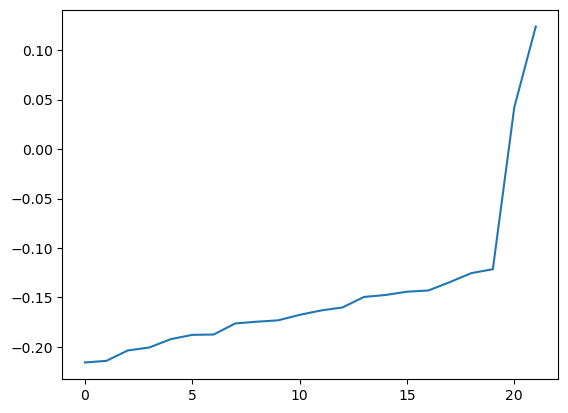

fit df.shape (307501, 40)


INFO:tensorflow:Assets written to: /tmp/tmpgbqif8d5/assets


INFO:tensorflow:Assets written to: /tmp/tmpgbqif8d5/assets
2022-11-22 07:43:20.706163: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:43:20.706286: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:43:20.706507: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgbqif8d5
2022-11-22 07:43:20.708680: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:43:20.708720: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpgbqif8d5
2022-11-22 07:43:20.716010: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:43:20.775402: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpgbqif8d5
2022-11-22 07:43:20.791799: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1p51t2tk/assets


INFO:tensorflow:Assets written to: /tmp/tmp1p51t2tk/assets
2022-11-22 07:43:22.563591: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:43:22.563696: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:43:22.563894: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1p51t2tk
2022-11-22 07:43:22.566028: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:43:22.566072: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1p51t2tk
2022-11-22 07:43:22.573262: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:43:22.632390: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1p51t2tk
2022-11-22 07:43:22.647676: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpd4qw2wm6/assets


INFO:tensorflow:Assets written to: /tmp/tmpd4qw2wm6/assets
2022-11-22 07:43:24.398661: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:43:24.398762: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:43:24.398985: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpd4qw2wm6
2022-11-22 07:43:24.401180: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:43:24.401226: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpd4qw2wm6
2022-11-22 07:43:24.408665: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:43:24.470439: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpd4qw2wm6
2022-11-22 07:43:24.487858: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpz1b10k2w/assets


INFO:tensorflow:Assets written to: /tmp/tmpz1b10k2w/assets
2022-11-22 07:43:26.247954: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:43:26.248039: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:43:26.248233: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpz1b10k2w
2022-11-22 07:43:26.250363: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:43:26.250409: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpz1b10k2w
2022-11-22 07:43:26.257588: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:43:26.318652: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpz1b10k2w
2022-11-22 07:43:26.334354: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpnou6uzbm/assets


INFO:tensorflow:Assets written to: /tmp/tmpnou6uzbm/assets
2022-11-22 07:43:29.463222: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:43:29.463320: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:43:29.463537: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpnou6uzbm
2022-11-22 07:43:29.468097: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:43:29.468164: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpnou6uzbm
2022-11-22 07:43:29.487884: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:43:29.577111: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpnou6uzbm
2022-11-22 07:43:29.607357: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpt2l40268/assets


INFO:tensorflow:Assets written to: /tmp/tmpt2l40268/assets
2022-11-22 07:43:31.605621: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:43:31.605724: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:43:31.605918: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpt2l40268
2022-11-22 07:43:31.608708: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:43:31.608765: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpt2l40268
2022-11-22 07:43:31.617075: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:43:31.680779: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpt2l40268
2022-11-22 07:43:31.697172: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpvkl27_f8/assets


INFO:tensorflow:Assets written to: /tmp/tmpvkl27_f8/assets
2022-11-22 07:43:33.487620: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:43:33.487727: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:43:33.487922: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpvkl27_f8
2022-11-22 07:43:33.490143: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:43:33.490192: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpvkl27_f8
2022-11-22 07:43:33.497667: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:43:33.559411: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpvkl27_f8
2022-11-22 07:43:33.575427: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6c9jfbh9/assets


INFO:tensorflow:Assets written to: /tmp/tmp6c9jfbh9/assets
2022-11-22 07:43:35.377286: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:43:35.377378: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:43:35.377572: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6c9jfbh9
2022-11-22 07:43:35.379752: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:43:35.379793: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6c9jfbh9
2022-11-22 07:43:35.386870: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:43:35.453448: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6c9jfbh9
2022-11-22 07:43:35.470761: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpliy_5w07/assets


INFO:tensorflow:Assets written to: /tmp/tmpliy_5w07/assets
2022-11-22 07:43:37.255230: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:43:37.255326: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:43:37.255522: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpliy_5w07
2022-11-22 07:43:37.257704: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:43:37.257761: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpliy_5w07
2022-11-22 07:43:37.265051: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:43:37.325230: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpliy_5w07
2022-11-22 07:43:37.341394: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9s611dxi/assets


INFO:tensorflow:Assets written to: /tmp/tmp9s611dxi/assets
2022-11-22 07:43:39.098822: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:43:39.098944: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:43:39.099142: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9s611dxi
2022-11-22 07:43:39.101528: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:43:39.101631: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9s611dxi
2022-11-22 07:43:39.109280: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:43:39.169873: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9s611dxi
2022-11-22 07:43:39.185954: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

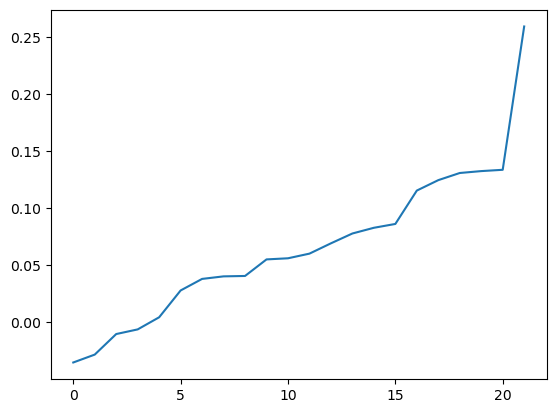

fit df.shape (283904, 40)


INFO:tensorflow:Assets written to: /tmp/tmpodrf2z3e/assets


INFO:tensorflow:Assets written to: /tmp/tmpodrf2z3e/assets
2022-11-22 07:52:32.809316: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:52:32.809414: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:52:32.809616: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpodrf2z3e
2022-11-22 07:52:32.811825: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:52:32.811872: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpodrf2z3e
2022-11-22 07:52:32.819035: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:52:32.877856: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpodrf2z3e
2022-11-22 07:52:32.893633: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpf06fpsqy/assets


INFO:tensorflow:Assets written to: /tmp/tmpf06fpsqy/assets
2022-11-22 07:52:34.663033: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:52:34.663126: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:52:34.663323: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpf06fpsqy
2022-11-22 07:52:34.665452: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:52:34.665496: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpf06fpsqy
2022-11-22 07:52:34.672681: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:52:34.731333: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpf06fpsqy
2022-11-22 07:52:34.746832: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmps6gaiszu/assets


INFO:tensorflow:Assets written to: /tmp/tmps6gaiszu/assets
2022-11-22 07:52:36.531857: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:52:36.531950: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:52:36.532142: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmps6gaiszu
2022-11-22 07:52:36.534277: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:52:36.534318: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmps6gaiszu
2022-11-22 07:52:36.541533: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:52:36.605328: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmps6gaiszu
2022-11-22 07:52:36.620927: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpjmmk97zm/assets


INFO:tensorflow:Assets written to: /tmp/tmpjmmk97zm/assets
2022-11-22 07:52:38.389942: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:52:38.390040: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:52:38.390240: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpjmmk97zm
2022-11-22 07:52:38.392455: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:52:38.392503: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpjmmk97zm
2022-11-22 07:52:38.399685: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:52:38.460725: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpjmmk97zm
2022-11-22 07:52:38.476589: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_ha4bhid/assets


INFO:tensorflow:Assets written to: /tmp/tmp_ha4bhid/assets
2022-11-22 07:52:40.234140: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:52:40.234233: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:52:40.234427: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_ha4bhid
2022-11-22 07:52:40.236644: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:52:40.236691: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_ha4bhid
2022-11-22 07:52:40.243781: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:52:40.302015: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_ha4bhid
2022-11-22 07:52:40.317504: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8gm5jk3q/assets


INFO:tensorflow:Assets written to: /tmp/tmp8gm5jk3q/assets
2022-11-22 07:52:42.065923: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:52:42.066019: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:52:42.066214: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8gm5jk3q
2022-11-22 07:52:42.068350: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:52:42.068391: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8gm5jk3q
2022-11-22 07:52:42.075535: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:52:42.135794: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8gm5jk3q
2022-11-22 07:52:42.151799: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_r7keu9t/assets


INFO:tensorflow:Assets written to: /tmp/tmp_r7keu9t/assets
2022-11-22 07:52:43.904396: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:52:43.904492: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:52:43.904686: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_r7keu9t
2022-11-22 07:52:43.906800: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:52:43.906844: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_r7keu9t
2022-11-22 07:52:43.913827: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:52:43.972263: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_r7keu9t
2022-11-22 07:52:43.987841: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpm7smn8r8/assets


INFO:tensorflow:Assets written to: /tmp/tmpm7smn8r8/assets
2022-11-22 07:52:45.746346: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:52:45.746432: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:52:45.746624: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpm7smn8r8
2022-11-22 07:52:45.748774: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:52:45.748814: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpm7smn8r8
2022-11-22 07:52:45.755712: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:52:45.813590: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpm7smn8r8
2022-11-22 07:52:45.829367: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8kphuoka/assets


INFO:tensorflow:Assets written to: /tmp/tmp8kphuoka/assets
2022-11-22 07:52:49.381950: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:52:49.382047: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:52:49.382246: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8kphuoka
2022-11-22 07:52:49.386306: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:52:49.386364: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8kphuoka
2022-11-22 07:52:49.398183: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:52:49.464904: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8kphuoka
2022-11-22 07:52:49.484636: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpuw5pps14/assets


INFO:tensorflow:Assets written to: /tmp/tmpuw5pps14/assets
2022-11-22 07:52:51.333043: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 07:52:51.333145: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 07:52:51.333342: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpuw5pps14
2022-11-22 07:52:51.335726: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 07:52:51.335775: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpuw5pps14
2022-11-22 07:52:51.343430: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 07:52:51.406739: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpuw5pps14
2022-11-22 07:52:51.423266: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

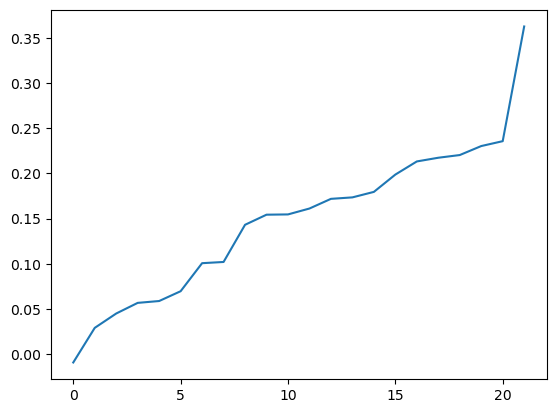

fit df.shape (244756, 40)


INFO:tensorflow:Assets written to: /tmp/tmp74gxo4y8/assets


INFO:tensorflow:Assets written to: /tmp/tmp74gxo4y8/assets
2022-11-22 08:00:52.313411: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:00:52.313506: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:00:52.313708: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp74gxo4y8
2022-11-22 08:00:52.315880: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:00:52.315923: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp74gxo4y8
2022-11-22 08:00:52.322954: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:00:52.381998: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp74gxo4y8
2022-11-22 08:00:52.397435: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp659lwep4/assets


INFO:tensorflow:Assets written to: /tmp/tmp659lwep4/assets
2022-11-22 08:00:54.152139: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:00:54.152224: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:00:54.152414: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp659lwep4
2022-11-22 08:00:54.154538: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:00:54.154575: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp659lwep4
2022-11-22 08:00:54.161478: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:00:54.219406: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp659lwep4
2022-11-22 08:00:54.235062: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0lqx0c6b/assets


INFO:tensorflow:Assets written to: /tmp/tmp0lqx0c6b/assets
2022-11-22 08:00:55.969739: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:00:55.969834: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:00:55.970028: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0lqx0c6b
2022-11-22 08:00:55.972200: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:00:55.972243: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0lqx0c6b
2022-11-22 08:00:55.979370: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:00:56.039947: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0lqx0c6b
2022-11-22 08:00:56.055485: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7zyak9c_/assets


INFO:tensorflow:Assets written to: /tmp/tmp7zyak9c_/assets
2022-11-22 08:00:57.796409: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:00:57.796494: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:00:57.796684: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7zyak9c_
2022-11-22 08:00:57.798813: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:00:57.798862: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7zyak9c_
2022-11-22 08:00:57.806026: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:00:57.865317: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7zyak9c_
2022-11-22 08:00:57.880748: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmproch0bwb/assets


INFO:tensorflow:Assets written to: /tmp/tmproch0bwb/assets
2022-11-22 08:00:59.596282: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:00:59.596368: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:00:59.596558: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmproch0bwb
2022-11-22 08:00:59.598673: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:00:59.598711: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmproch0bwb
2022-11-22 08:00:59.605738: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:00:59.664209: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmproch0bwb
2022-11-22 08:00:59.679473: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp9u679jg8/assets


INFO:tensorflow:Assets written to: /tmp/tmp9u679jg8/assets
2022-11-22 08:01:01.417568: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:01:01.417654: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:01:01.417858: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9u679jg8
2022-11-22 08:01:01.420039: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:01:01.420080: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9u679jg8
2022-11-22 08:01:01.426937: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:01:01.484759: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9u679jg8
2022-11-22 08:01:01.500020: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpmlo5l5wn/assets


INFO:tensorflow:Assets written to: /tmp/tmpmlo5l5wn/assets
2022-11-22 08:01:03.234978: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:01:03.235062: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:01:03.235252: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmlo5l5wn
2022-11-22 08:01:03.237364: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:01:03.237404: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmlo5l5wn
2022-11-22 08:01:03.244366: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:01:03.301990: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpmlo5l5wn
2022-11-22 08:01:03.317338: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7o2vh51k/assets


INFO:tensorflow:Assets written to: /tmp/tmp7o2vh51k/assets
2022-11-22 08:01:05.048065: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:01:05.048151: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:01:05.048342: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7o2vh51k
2022-11-22 08:01:05.050448: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:01:05.050487: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7o2vh51k
2022-11-22 08:01:05.057508: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:01:05.116999: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7o2vh51k
2022-11-22 08:01:05.132889: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbddx65xy/assets


INFO:tensorflow:Assets written to: /tmp/tmpbddx65xy/assets
2022-11-22 08:01:06.865922: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:01:06.866012: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:01:06.866205: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbddx65xy
2022-11-22 08:01:06.868328: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:01:06.868368: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbddx65xy
2022-11-22 08:01:06.875171: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:01:06.932178: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbddx65xy
2022-11-22 08:01:06.947292: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplj8peh89/assets


INFO:tensorflow:Assets written to: /tmp/tmplj8peh89/assets
2022-11-22 08:01:08.677201: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:01:08.677287: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:01:08.677475: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplj8peh89
2022-11-22 08:01:08.679634: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:01:08.679680: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplj8peh89
2022-11-22 08:01:08.686694: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:01:08.744942: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplj8peh89
2022-11-22 08:01:08.759889: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

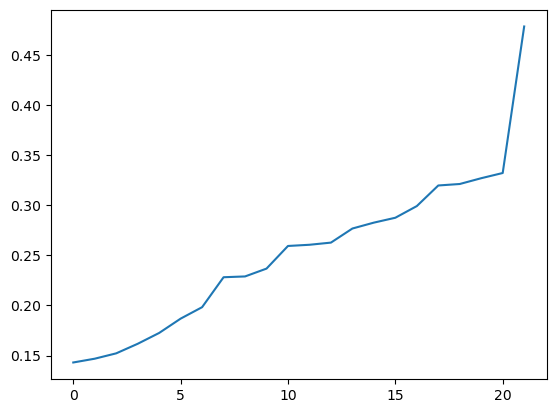

fit df.shape (226471, 40)


INFO:tensorflow:Assets written to: /tmp/tmp9slwpxlo/assets


INFO:tensorflow:Assets written to: /tmp/tmp9slwpxlo/assets
2022-11-22 08:09:18.430171: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:09:18.430270: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:09:18.430478: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9slwpxlo
2022-11-22 08:09:18.432744: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:09:18.432797: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp9slwpxlo
2022-11-22 08:09:18.440232: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:09:18.502380: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp9slwpxlo
2022-11-22 08:09:18.519143: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpx1gomuc3/assets


INFO:tensorflow:Assets written to: /tmp/tmpx1gomuc3/assets
2022-11-22 08:09:20.322196: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:09:20.322293: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:09:20.322488: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpx1gomuc3
2022-11-22 08:09:20.324650: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:09:20.324696: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpx1gomuc3
2022-11-22 08:09:20.331891: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:09:20.391697: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpx1gomuc3
2022-11-22 08:09:20.407862: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp81nx1odb/assets


INFO:tensorflow:Assets written to: /tmp/tmp81nx1odb/assets
2022-11-22 08:09:22.201207: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:09:22.201306: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:09:22.201503: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp81nx1odb
2022-11-22 08:09:22.203690: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:09:22.203735: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp81nx1odb
2022-11-22 08:09:22.210934: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:09:22.271125: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp81nx1odb
2022-11-22 08:09:22.287447: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpb3inlovv/assets


INFO:tensorflow:Assets written to: /tmp/tmpb3inlovv/assets
2022-11-22 08:09:24.092367: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:09:24.092467: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:09:24.092667: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpb3inlovv
2022-11-22 08:09:24.094811: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:09:24.094855: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpb3inlovv
2022-11-22 08:09:24.102033: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:09:24.162236: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpb3inlovv
2022-11-22 08:09:24.178778: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp0k_20erz/assets


INFO:tensorflow:Assets written to: /tmp/tmp0k_20erz/assets
2022-11-22 08:09:25.997997: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:09:25.998088: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:09:25.998279: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp0k_20erz
2022-11-22 08:09:26.000552: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:09:26.000600: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp0k_20erz
2022-11-22 08:09:26.007916: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:09:26.068557: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp0k_20erz
2022-11-22 08:09:26.084248: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpb405gnr8/assets


INFO:tensorflow:Assets written to: /tmp/tmpb405gnr8/assets
2022-11-22 08:09:27.872275: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:09:27.872364: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:09:27.872556: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpb405gnr8
2022-11-22 08:09:27.874650: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:09:27.874693: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpb405gnr8
2022-11-22 08:09:27.881637: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:09:27.941514: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpb405gnr8
2022-11-22 08:09:27.957344: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpn9z51ywg/assets


INFO:tensorflow:Assets written to: /tmp/tmpn9z51ywg/assets
2022-11-22 08:09:29.701932: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:09:29.702018: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:09:29.702210: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpn9z51ywg
2022-11-22 08:09:29.704419: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:09:29.704466: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpn9z51ywg
2022-11-22 08:09:29.711645: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:09:29.770459: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpn9z51ywg
2022-11-22 08:09:29.785990: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpr0bxkp99/assets


INFO:tensorflow:Assets written to: /tmp/tmpr0bxkp99/assets
2022-11-22 08:09:31.580100: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:09:31.580196: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:09:31.580390: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpr0bxkp99
2022-11-22 08:09:31.582519: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:09:31.582563: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpr0bxkp99
2022-11-22 08:09:31.589825: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:09:31.649257: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpr0bxkp99
2022-11-22 08:09:31.665075: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp90zyxz7q/assets


INFO:tensorflow:Assets written to: /tmp/tmp90zyxz7q/assets
2022-11-22 08:09:33.446290: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:09:33.446391: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:09:33.446586: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp90zyxz7q
2022-11-22 08:09:33.448730: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:09:33.448776: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp90zyxz7q
2022-11-22 08:09:33.456071: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:09:33.517801: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp90zyxz7q
2022-11-22 08:09:33.534297: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6i4jc2s9/assets


INFO:tensorflow:Assets written to: /tmp/tmp6i4jc2s9/assets
2022-11-22 08:09:35.308909: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 08:09:35.308998: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 08:09:35.309191: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6i4jc2s9
2022-11-22 08:09:35.311325: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 08:09:35.311371: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6i4jc2s9
2022-11-22 08:09:35.321012: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 08:09:35.383361: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6i4jc2s9
2022-11-22 08:09:35.399367: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

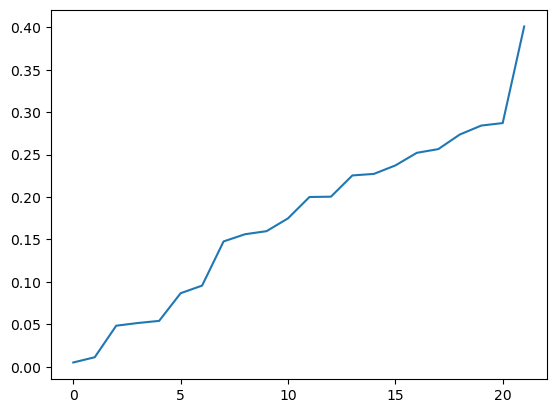

return without cost statistics
mean 0.0018316312960193956
std 0.020801320708626028
sharpe 0.088053605906852
double sharpe 1.3083624993528056
max drawdown 5.84207669526372
min -0.5711515739392516
min sharpe 0.003206909303228516
return with cost statistics
mean 0.0007960904078946179
std 0.020804318632965613
sharpe 0.038265632340064616
double sharpe 0.2868626776386072
max drawdown 7.16285702144873
min -0.5726515740104978
min sharpe 0.0013901828686495917


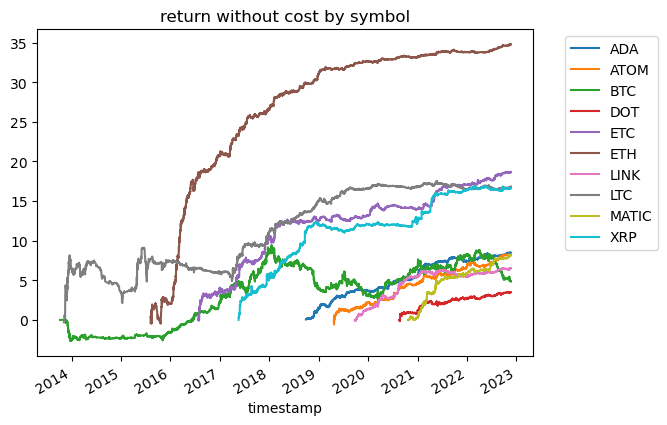

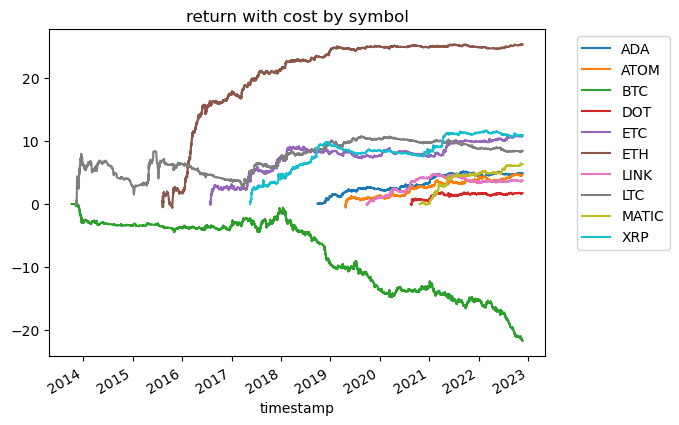

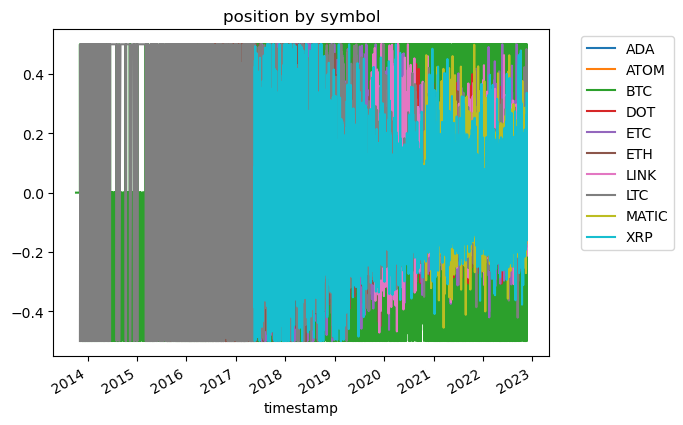

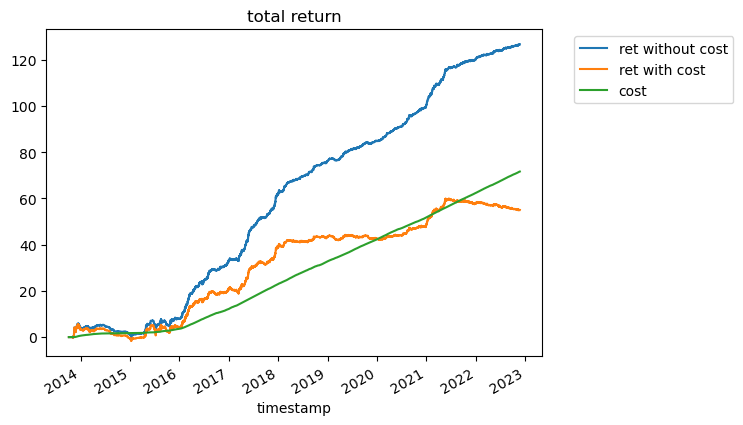

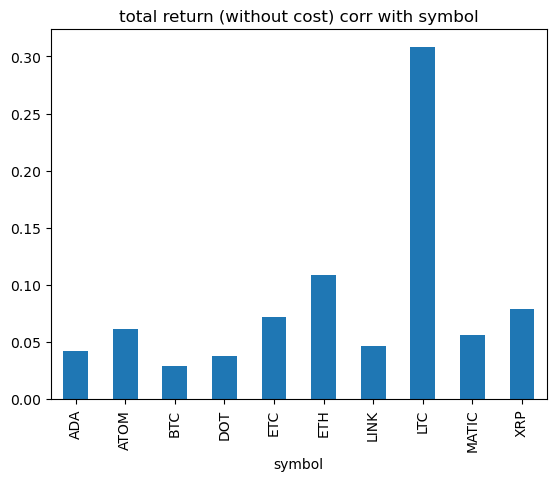

return without cost statistics
mean 0.0014361955983314373
std 0.009730078150562354
sharpe 0.14760370637397519
double sharpe 1.201071927831144
max drawdown 2.1692936265761844
min -0.1304559628178122
min sharpe 0.011009045254122659
return with cost statistics
mean 0.00036740618336223704
std 0.009728704198920836
sharpe 0.03776517158400107
double sharpe 0.10501512164574772
max drawdown 5.097937308459112
min -0.13218170407244362
min sharpe 0.002779553993046391


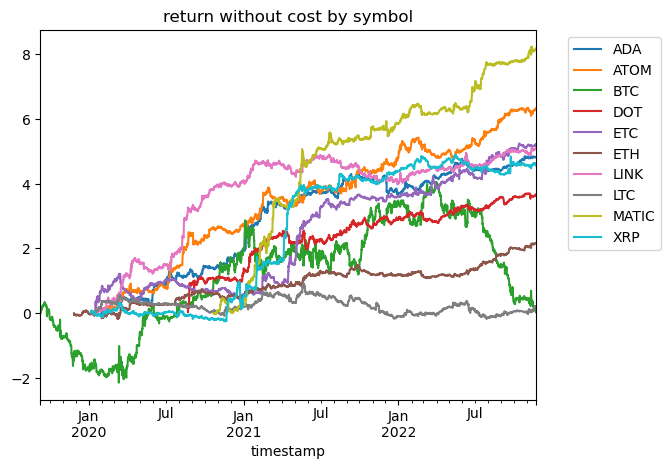

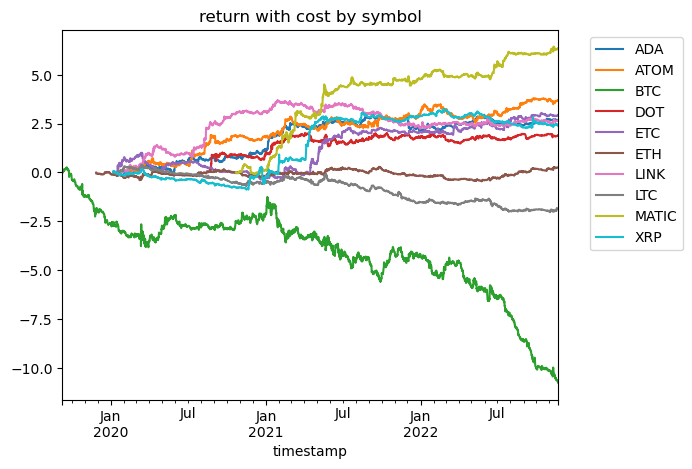

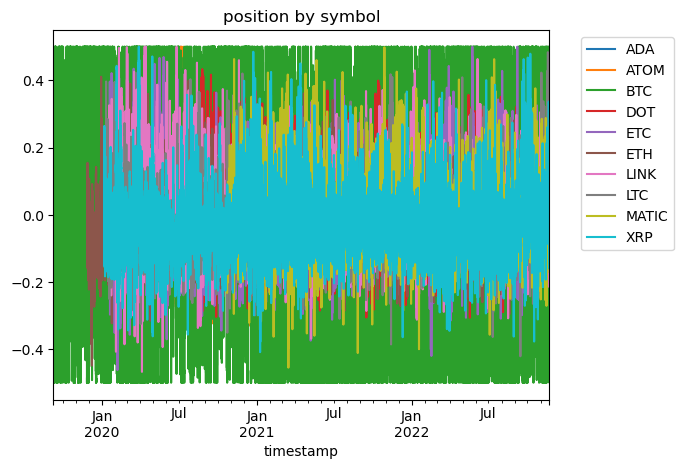

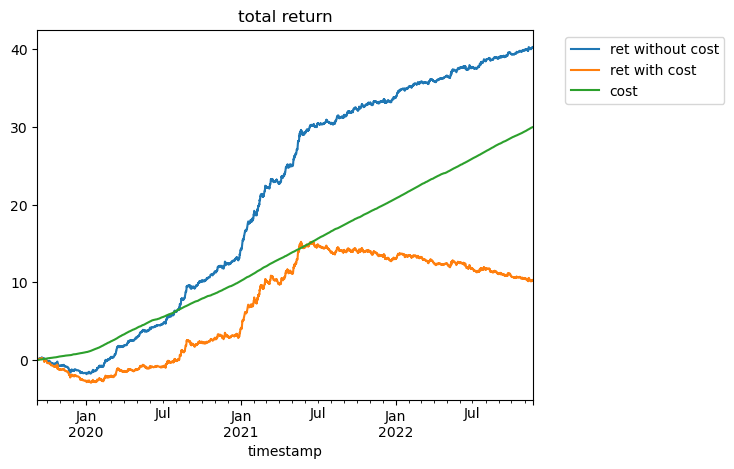

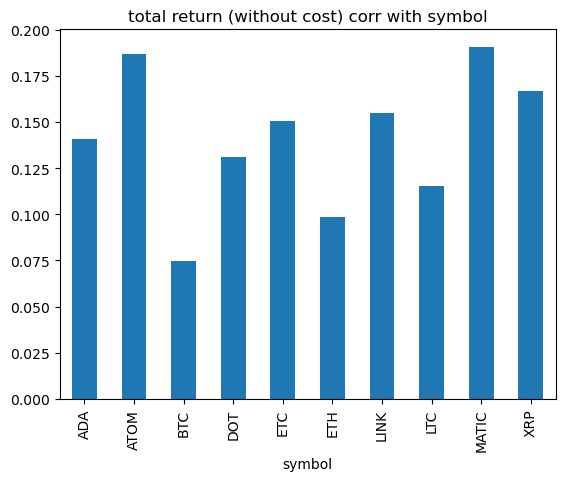

fit df.shape (351166, 40)


INFO:tensorflow:Assets written to: /tmp/tmpk8rulfep/assets


INFO:tensorflow:Assets written to: /tmp/tmpk8rulfep/assets
2022-11-22 10:12:40.024607: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:12:40.024707: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:12:40.024919: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpk8rulfep
2022-11-22 10:12:40.027158: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:12:40.027213: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpk8rulfep
2022-11-22 10:12:40.034920: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:12:40.098120: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpk8rulfep
2022-11-22 10:12:40.115528: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdy7mee7u/assets


INFO:tensorflow:Assets written to: /tmp/tmpdy7mee7u/assets
2022-11-22 10:12:43.701255: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:12:43.701342: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:12:43.701546: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdy7mee7u
2022-11-22 10:12:43.706076: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:12:43.706141: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdy7mee7u
2022-11-22 10:12:43.720857: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:12:43.796948: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdy7mee7u
2022-11-22 10:12:43.820479: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpldx12qd7/assets


INFO:tensorflow:Assets written to: /tmp/tmpldx12qd7/assets
2022-11-22 10:12:45.748540: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:12:45.748638: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:12:45.748849: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpldx12qd7
2022-11-22 10:12:45.751197: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:12:45.751251: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpldx12qd7
2022-11-22 10:12:45.758642: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:12:45.821603: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpldx12qd7
2022-11-22 10:12:45.837970: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpb8su_d4b/assets


INFO:tensorflow:Assets written to: /tmp/tmpb8su_d4b/assets
2022-11-22 10:12:47.666021: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:12:47.666116: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:12:47.666321: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpb8su_d4b
2022-11-22 10:12:47.668506: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:12:47.668561: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpb8su_d4b
2022-11-22 10:12:47.676006: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:12:47.738175: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpb8su_d4b
2022-11-22 10:12:47.754162: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6tyd80hn/assets


INFO:tensorflow:Assets written to: /tmp/tmp6tyd80hn/assets
2022-11-22 10:12:49.598078: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:12:49.598182: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:12:49.598398: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6tyd80hn
2022-11-22 10:12:49.600676: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:12:49.600728: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6tyd80hn
2022-11-22 10:12:49.608149: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:12:49.671257: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6tyd80hn
2022-11-22 10:12:49.689426: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1ewfdwgx/assets


INFO:tensorflow:Assets written to: /tmp/tmp1ewfdwgx/assets
2022-11-22 10:12:51.511296: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:12:51.511390: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:12:51.511588: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1ewfdwgx
2022-11-22 10:12:51.513763: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:12:51.513818: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1ewfdwgx
2022-11-22 10:12:51.521277: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:12:51.585003: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1ewfdwgx
2022-11-22 10:12:51.601679: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpm12gvado/assets


INFO:tensorflow:Assets written to: /tmp/tmpm12gvado/assets
2022-11-22 10:12:53.425637: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:12:53.425734: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:12:53.425937: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpm12gvado
2022-11-22 10:12:53.428181: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:12:53.428233: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpm12gvado
2022-11-22 10:12:53.435746: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:12:53.500418: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpm12gvado
2022-11-22 10:12:53.518156: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpd748njj7/assets


INFO:tensorflow:Assets written to: /tmp/tmpd748njj7/assets
2022-11-22 10:12:55.359767: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:12:55.359869: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:12:55.360066: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpd748njj7
2022-11-22 10:12:55.362272: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:12:55.362323: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpd748njj7
2022-11-22 10:12:55.369723: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:12:55.431050: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpd748njj7
2022-11-22 10:12:55.446893: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5v8zer0x/assets


INFO:tensorflow:Assets written to: /tmp/tmp5v8zer0x/assets
2022-11-22 10:12:57.269588: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:12:57.269680: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:12:57.269885: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5v8zer0x
2022-11-22 10:12:57.272106: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:12:57.272156: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5v8zer0x
2022-11-22 10:12:57.279590: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:12:57.344261: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5v8zer0x
2022-11-22 10:12:57.361128: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpi_og4u2p/assets


INFO:tensorflow:Assets written to: /tmp/tmpi_og4u2p/assets
2022-11-22 10:12:59.195690: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:12:59.195798: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:12:59.195998: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpi_og4u2p
2022-11-22 10:12:59.198164: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:12:59.198216: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpi_og4u2p
2022-11-22 10:12:59.205697: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:12:59.267330: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpi_og4u2p
2022-11-22 10:12:59.283979: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpctlkq53_/assets


INFO:tensorflow:Assets written to: /tmp/tmpctlkq53_/assets
2022-11-22 10:13:01.141621: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:13:01.141715: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:13:01.141922: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpctlkq53_
2022-11-22 10:13:01.144117: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:13:01.144168: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpctlkq53_
2022-11-22 10:13:01.151566: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:13:01.212528: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpctlkq53_
2022-11-22 10:13:01.230739: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxhnzx334/assets


INFO:tensorflow:Assets written to: /tmp/tmpxhnzx334/assets
2022-11-22 10:13:03.067710: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:13:03.067816: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:13:03.068012: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxhnzx334
2022-11-22 10:13:03.070178: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:13:03.070234: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxhnzx334
2022-11-22 10:13:03.077680: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:13:03.140401: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxhnzx334
2022-11-22 10:13:03.156911: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpbtoy_eas/assets


INFO:tensorflow:Assets written to: /tmp/tmpbtoy_eas/assets
2022-11-22 10:13:05.019887: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:13:05.019980: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:13:05.020175: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpbtoy_eas
2022-11-22 10:13:05.022351: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:13:05.022406: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpbtoy_eas
2022-11-22 10:13:05.029904: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:13:05.096183: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpbtoy_eas
2022-11-22 10:13:05.113562: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmps4hifg2m/assets


INFO:tensorflow:Assets written to: /tmp/tmps4hifg2m/assets
2022-11-22 10:13:06.985162: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:13:06.985261: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:13:06.985460: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmps4hifg2m
2022-11-22 10:13:06.987652: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:13:06.987704: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmps4hifg2m
2022-11-22 10:13:06.995159: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:13:07.058803: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmps4hifg2m
2022-11-22 10:13:07.076193: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxrjd6z53/assets


INFO:tensorflow:Assets written to: /tmp/tmpxrjd6z53/assets
2022-11-22 10:13:08.936314: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:13:08.936408: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:13:08.936605: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxrjd6z53
2022-11-22 10:13:08.938763: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:13:08.938814: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxrjd6z53
2022-11-22 10:13:08.946587: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:13:09.013722: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxrjd6z53
2022-11-22 10:13:09.032329: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp19mto35e/assets


INFO:tensorflow:Assets written to: /tmp/tmp19mto35e/assets
2022-11-22 10:13:10.884106: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:13:10.884211: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:13:10.884409: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp19mto35e
2022-11-22 10:13:10.886576: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:13:10.886623: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp19mto35e
2022-11-22 10:13:10.894296: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:13:10.956211: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp19mto35e
2022-11-22 10:13:10.973303: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpw6gyhw7g/assets


INFO:tensorflow:Assets written to: /tmp/tmpw6gyhw7g/assets
2022-11-22 10:13:15.915543: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:13:15.915650: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:13:15.915865: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpw6gyhw7g
2022-11-22 10:13:15.921724: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:13:15.921795: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpw6gyhw7g
2022-11-22 10:13:15.950511: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:13:16.110960: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpw6gyhw7g
2022-11-22 10:13:16.164865: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2onj9i1x/assets


INFO:tensorflow:Assets written to: /tmp/tmp2onj9i1x/assets
2022-11-22 10:13:18.526670: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:13:18.526779: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:13:18.527006: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2onj9i1x
2022-11-22 10:13:18.532130: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:13:18.532199: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2onj9i1x
2022-11-22 10:13:18.552996: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:13:18.670203: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2onj9i1x
2022-11-22 10:13:18.702705: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqbkbg4_4/assets


INFO:tensorflow:Assets written to: /tmp/tmpqbkbg4_4/assets
2022-11-22 10:13:20.877515: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:13:20.877613: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:13:20.877827: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqbkbg4_4
2022-11-22 10:13:20.881766: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:13:20.881837: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqbkbg4_4
2022-11-22 10:13:20.894090: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:13:20.965233: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqbkbg4_4
2022-11-22 10:13:20.986170: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpyy1e10fc/assets


INFO:tensorflow:Assets written to: /tmp/tmpyy1e10fc/assets
2022-11-22 10:13:22.944704: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:13:22.944803: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:13:22.945000: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpyy1e10fc
2022-11-22 10:13:22.947585: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:13:22.947640: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpyy1e10fc
2022-11-22 10:13:22.956116: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:13:23.028288: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpyy1e10fc
2022-11-22 10:13:23.048257: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpp4b1nkb_/assets


INFO:tensorflow:Assets written to: /tmp/tmpp4b1nkb_/assets
2022-11-22 10:13:24.936888: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:13:24.936989: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:13:24.937188: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpp4b1nkb_
2022-11-22 10:13:24.939529: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:13:24.939585: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpp4b1nkb_
2022-11-22 10:13:24.947233: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:13:25.014172: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpp4b1nkb_
2022-11-22 10:13:25.031635: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp54o_gbr8/assets


INFO:tensorflow:Assets written to: /tmp/tmp54o_gbr8/assets
2022-11-22 10:13:26.897636: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:13:26.897739: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:13:26.897933: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp54o_gbr8
2022-11-22 10:13:26.900221: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:13:26.900273: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp54o_gbr8
2022-11-22 10:13:26.907708: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:13:26.971036: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp54o_gbr8
2022-11-22 10:13:26.988274: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpq0n_yfns/assets


INFO:tensorflow:Assets written to: /tmp/tmpq0n_yfns/assets
2022-11-22 10:13:28.856184: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:13:28.856268: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:13:28.856463: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpq0n_yfns
2022-11-22 10:13:28.858691: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:13:28.858754: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpq0n_yfns
2022-11-22 10:13:28.866142: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:13:28.928817: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpq0n_yfns
2022-11-22 10:13:28.945450: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpo7_2wmv8/assets


INFO:tensorflow:Assets written to: /tmp/tmpo7_2wmv8/assets
2022-11-22 10:13:30.812754: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:13:30.812858: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:13:30.813057: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpo7_2wmv8
2022-11-22 10:13:30.815263: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:13:30.815316: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpo7_2wmv8
2022-11-22 10:13:30.822565: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:13:30.884127: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpo7_2wmv8
2022-11-22 10:13:30.901471: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpwweumkva/assets


INFO:tensorflow:Assets written to: /tmp/tmpwweumkva/assets
2022-11-22 10:13:32.748317: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:13:32.748420: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:13:32.748618: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwweumkva
2022-11-22 10:13:32.750759: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:13:32.750809: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwweumkva
2022-11-22 10:13:32.758101: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:13:32.820563: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwweumkva
2022-11-22 10:13:32.837032: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5isgq1ux/assets


INFO:tensorflow:Assets written to: /tmp/tmp5isgq1ux/assets
2022-11-22 10:13:34.672483: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:13:34.672579: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:13:34.672794: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5isgq1ux
2022-11-22 10:13:34.674965: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:13:34.675013: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5isgq1ux
2022-11-22 10:13:34.682319: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:13:34.744417: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5isgq1ux
2022-11-22 10:13:34.761506: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7fkhq6if/assets


INFO:tensorflow:Assets written to: /tmp/tmp7fkhq6if/assets
2022-11-22 10:13:36.610960: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:13:36.611056: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:13:36.611263: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7fkhq6if
2022-11-22 10:13:36.613440: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:13:36.613490: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7fkhq6if
2022-11-22 10:13:36.620768: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:13:36.682533: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7fkhq6if
2022-11-22 10:13:36.699129: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_wco0f6b/assets


INFO:tensorflow:Assets written to: /tmp/tmp_wco0f6b/assets
2022-11-22 10:13:38.562720: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:13:38.562824: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:13:38.563040: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_wco0f6b
2022-11-22 10:13:38.565244: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:13:38.565295: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_wco0f6b
2022-11-22 10:13:38.572863: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:13:38.641432: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_wco0f6b
2022-11-22 10:13:38.659326: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpf1d1676z/assets


INFO:tensorflow:Assets written to: /tmp/tmpf1d1676z/assets
2022-11-22 10:13:43.370523: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:13:43.370621: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:13:43.370832: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpf1d1676z
2022-11-22 10:13:43.376583: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:13:43.376651: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpf1d1676z
2022-11-22 10:13:43.402123: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:13:43.552377: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpf1d1676z
2022-11-22 10:13:43.599497: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2bngab_9/assets


INFO:tensorflow:Assets written to: /tmp/tmp2bngab_9/assets
2022-11-22 10:13:45.940517: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:13:45.940615: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:13:45.940826: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2bngab_9
2022-11-22 10:13:45.945798: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:13:45.945871: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2bngab_9
2022-11-22 10:13:45.965758: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:13:46.070338: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2bngab_9
2022-11-22 10:13:46.103433: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_i27t4de/assets


INFO:tensorflow:Assets written to: /tmp/tmp_i27t4de/assets
2022-11-22 10:13:48.219802: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:13:48.219902: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:13:48.220104: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_i27t4de
2022-11-22 10:13:48.223753: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:13:48.223820: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_i27t4de
2022-11-22 10:13:48.235327: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:13:48.309038: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_i27t4de
2022-11-22 10:13:48.328767: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzgz03_kv/assets


INFO:tensorflow:Assets written to: /tmp/tmpzgz03_kv/assets
2022-11-22 10:13:50.282000: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:13:50.282100: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:13:50.282299: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzgz03_kv
2022-11-22 10:13:50.284847: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:13:50.284903: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzgz03_kv
2022-11-22 10:13:50.293452: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:13:50.361038: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzgz03_kv
2022-11-22 10:13:50.379524: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_iunj6xd/assets


INFO:tensorflow:Assets written to: /tmp/tmp_iunj6xd/assets
2022-11-22 10:13:52.309053: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:13:52.309157: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:13:52.309359: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_iunj6xd
2022-11-22 10:13:52.311769: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:13:52.311836: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_iunj6xd
2022-11-22 10:13:52.319803: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:13:52.385870: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_iunj6xd
2022-11-22 10:13:52.403250: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpmtkvp68f/assets


INFO:tensorflow:Assets written to: /tmp/tmpmtkvp68f/assets
2022-11-22 10:13:54.360055: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:13:54.360154: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:13:54.360355: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpmtkvp68f
2022-11-22 10:13:54.362866: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:13:54.362981: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpmtkvp68f
2022-11-22 10:13:54.372156: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:13:54.453078: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpmtkvp68f
2022-11-22 10:13:54.479165: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp5shsp881/assets


INFO:tensorflow:Assets written to: /tmp/tmp5shsp881/assets
2022-11-22 10:13:56.389716: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:13:56.389815: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:13:56.390013: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp5shsp881
2022-11-22 10:13:56.392621: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:13:56.392686: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp5shsp881
2022-11-22 10:13:56.400502: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:13:56.464835: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp5shsp881
2022-11-22 10:13:56.483133: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpdjj4nl16/assets


INFO:tensorflow:Assets written to: /tmp/tmpdjj4nl16/assets
2022-11-22 10:13:58.332662: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:13:58.332757: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:13:58.332966: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpdjj4nl16
2022-11-22 10:13:58.335190: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:13:58.335240: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpdjj4nl16
2022-11-22 10:13:58.343104: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:13:58.404951: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpdjj4nl16
2022-11-22 10:13:58.421381: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzhnjqisc/assets


INFO:tensorflow:Assets written to: /tmp/tmpzhnjqisc/assets
2022-11-22 10:14:00.306451: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:14:00.306551: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:14:00.306752: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzhnjqisc
2022-11-22 10:14:00.308941: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:14:00.308995: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzhnjqisc
2022-11-22 10:14:00.316945: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:14:00.386009: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzhnjqisc
2022-11-22 10:14:00.406082: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpstpygwiz/assets


INFO:tensorflow:Assets written to: /tmp/tmpstpygwiz/assets
2022-11-22 10:14:02.306163: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:14:02.306260: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:14:02.306454: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpstpygwiz
2022-11-22 10:14:02.308636: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:14:02.308682: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpstpygwiz
2022-11-22 10:14:02.315945: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:14:02.377316: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpstpygwiz
2022-11-22 10:14:02.394032: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpldimwbhn/assets


INFO:tensorflow:Assets written to: /tmp/tmpldimwbhn/assets
2022-11-22 10:14:04.246140: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:14:04.246228: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:14:04.246421: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpldimwbhn
2022-11-22 10:14:04.248619: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:14:04.248669: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpldimwbhn
2022-11-22 10:14:04.256150: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:14:04.318211: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpldimwbhn
2022-11-22 10:14:04.335286: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpuqloh902/assets


INFO:tensorflow:Assets written to: /tmp/tmpuqloh902/assets
2022-11-22 10:14:08.845662: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:14:08.845768: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:14:08.845990: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpuqloh902
2022-11-22 10:14:08.852041: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:14:08.852111: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpuqloh902
2022-11-22 10:14:08.876773: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:14:09.028363: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpuqloh902
2022-11-22 10:14:09.075707: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqg5h15cu/assets


INFO:tensorflow:Assets written to: /tmp/tmpqg5h15cu/assets
2022-11-22 10:14:11.393947: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:14:11.394046: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:14:11.394254: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqg5h15cu
2022-11-22 10:14:11.398959: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:14:11.399028: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqg5h15cu
2022-11-22 10:14:11.417903: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:14:11.533677: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqg5h15cu
2022-11-22 10:14:11.567323: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2z5585zq/assets


INFO:tensorflow:Assets written to: /tmp/tmp2z5585zq/assets
2022-11-22 10:14:13.736537: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:14:13.736633: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:14:13.736841: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2z5585zq
2022-11-22 10:14:13.740758: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:14:13.740826: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2z5585zq
2022-11-22 10:14:13.752594: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:14:13.823483: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2z5585zq
2022-11-22 10:14:13.844551: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxsdobi4l/assets


INFO:tensorflow:Assets written to: /tmp/tmpxsdobi4l/assets
2022-11-22 10:14:15.809826: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:14:15.809925: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:14:15.810120: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxsdobi4l
2022-11-22 10:14:15.812692: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:14:15.812752: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxsdobi4l
2022-11-22 10:14:15.821581: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:14:15.889402: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxsdobi4l
2022-11-22 10:14:15.908904: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6d6qaqck/assets


INFO:tensorflow:Assets written to: /tmp/tmp6d6qaqck/assets
2022-11-22 10:14:17.830244: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:14:17.830347: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:14:17.830543: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6d6qaqck
2022-11-22 10:14:17.832974: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:14:17.833034: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6d6qaqck
2022-11-22 10:14:17.841145: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:14:17.908546: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6d6qaqck
2022-11-22 10:14:17.926378: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp_hxp3855/assets


INFO:tensorflow:Assets written to: /tmp/tmp_hxp3855/assets
2022-11-22 10:14:19.891836: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:14:19.891946: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:14:19.892160: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp_hxp3855
2022-11-22 10:14:19.894520: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:14:19.894585: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp_hxp3855
2022-11-22 10:14:19.903066: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:14:19.977681: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp_hxp3855
2022-11-22 10:14:19.995988: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpyc_jqdey/assets


INFO:tensorflow:Assets written to: /tmp/tmpyc_jqdey/assets
2022-11-22 10:14:21.901758: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:14:21.901871: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:14:21.902073: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpyc_jqdey
2022-11-22 10:14:21.904398: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:14:21.904453: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpyc_jqdey
2022-11-22 10:14:21.912249: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:14:21.977399: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpyc_jqdey
2022-11-22 10:14:21.995197: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpywf2ebxx/assets


INFO:tensorflow:Assets written to: /tmp/tmpywf2ebxx/assets
2022-11-22 10:14:23.917391: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:14:23.917493: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:14:23.917693: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpywf2ebxx
2022-11-22 10:14:23.920202: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:14:23.920269: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpywf2ebxx
2022-11-22 10:14:23.928126: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:14:23.995340: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpywf2ebxx
2022-11-22 10:14:24.014497: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzz0b4cw_/assets


INFO:tensorflow:Assets written to: /tmp/tmpzz0b4cw_/assets
2022-11-22 10:14:25.953471: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:14:25.953572: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:14:25.953787: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzz0b4cw_
2022-11-22 10:14:25.956165: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:14:25.956233: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzz0b4cw_
2022-11-22 10:14:25.963906: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:14:26.029200: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzz0b4cw_
2022-11-22 10:14:26.047983: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpxbp4x6qf/assets


INFO:tensorflow:Assets written to: /tmp/tmpxbp4x6qf/assets
2022-11-22 10:14:30.362651: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:14:30.362745: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:14:30.362982: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpxbp4x6qf
2022-11-22 10:14:30.368966: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:14:30.369036: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpxbp4x6qf
2022-11-22 10:14:30.401439: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:14:30.584013: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpxbp4x6qf
2022-11-22 10:14:30.642736: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzntmpia_/assets


INFO:tensorflow:Assets written to: /tmp/tmpzntmpia_/assets
2022-11-22 10:14:33.115522: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:14:33.115617: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:14:33.115837: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzntmpia_
2022-11-22 10:14:33.121301: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:14:33.121372: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzntmpia_
2022-11-22 10:14:33.143392: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:14:33.259974: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzntmpia_
2022-11-22 10:14:33.297593: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8uygruyp/assets


INFO:tensorflow:Assets written to: /tmp/tmp8uygruyp/assets
2022-11-22 10:14:35.575126: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:14:35.575221: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:14:35.575435: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8uygruyp
2022-11-22 10:14:35.579974: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:14:35.580040: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8uygruyp
2022-11-22 10:14:35.600353: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:14:35.709114: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8uygruyp
2022-11-22 10:14:35.742432: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmptuopm3vp/assets


INFO:tensorflow:Assets written to: /tmp/tmptuopm3vp/assets
2022-11-22 10:14:37.863794: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:14:37.863889: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:14:37.864088: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmptuopm3vp
2022-11-22 10:14:37.866798: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:14:37.866856: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmptuopm3vp
2022-11-22 10:14:37.876199: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:14:37.950739: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmptuopm3vp
2022-11-22 10:14:37.972052: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpttc4hukv/assets


INFO:tensorflow:Assets written to: /tmp/tmpttc4hukv/assets
2022-11-22 10:14:39.971947: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:14:39.972045: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:14:39.972283: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpttc4hukv
2022-11-22 10:14:39.974768: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:14:39.974828: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpttc4hukv
2022-11-22 10:14:39.983565: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:14:40.057371: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpttc4hukv
2022-11-22 10:14:40.077589: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp24k06det/assets


INFO:tensorflow:Assets written to: /tmp/tmp24k06det/assets
2022-11-22 10:14:42.033236: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:14:42.033337: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:14:42.033548: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp24k06det
2022-11-22 10:14:42.035859: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:14:42.035916: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp24k06det
2022-11-22 10:14:42.043962: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:14:42.111124: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp24k06det
2022-11-22 10:14:42.129443: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp6xg0k92v/assets


INFO:tensorflow:Assets written to: /tmp/tmp6xg0k92v/assets
2022-11-22 10:14:44.033938: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:14:44.034034: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:14:44.034236: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp6xg0k92v
2022-11-22 10:14:44.036503: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:14:44.036556: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp6xg0k92v
2022-11-22 10:14:44.044252: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:14:44.110582: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp6xg0k92v
2022-11-22 10:14:44.128330: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpal3vcr6k/assets


INFO:tensorflow:Assets written to: /tmp/tmpal3vcr6k/assets
2022-11-22 10:14:46.042428: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:14:46.042531: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:14:46.042731: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpal3vcr6k
2022-11-22 10:14:46.044989: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:14:46.045041: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpal3vcr6k
2022-11-22 10:14:46.052787: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:14:46.116698: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpal3vcr6k
2022-11-22 10:14:46.134294: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmplym85n1n/assets


INFO:tensorflow:Assets written to: /tmp/tmplym85n1n/assets
2022-11-22 10:14:47.998796: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:14:47.998894: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:14:47.999107: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmplym85n1n
2022-11-22 10:14:48.001341: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:14:48.001395: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmplym85n1n
2022-11-22 10:14:48.009289: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:14:48.074244: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmplym85n1n
2022-11-22 10:14:48.091158: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpqc4oo32r/assets


INFO:tensorflow:Assets written to: /tmp/tmpqc4oo32r/assets
2022-11-22 10:14:52.475880: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:14:52.475976: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:14:52.476192: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqc4oo32r
2022-11-22 10:14:52.482292: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:14:52.482363: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpqc4oo32r
2022-11-22 10:14:52.513308: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:14:52.688051: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpqc4oo32r
2022-11-22 10:14:52.741092: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp944_artf/assets


INFO:tensorflow:Assets written to: /tmp/tmp944_artf/assets
2022-11-22 10:14:55.190178: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:14:55.190281: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:14:55.190498: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp944_artf
2022-11-22 10:14:55.196061: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:14:55.196128: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp944_artf
2022-11-22 10:14:55.218791: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:14:55.344804: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp944_artf
2022-11-22 10:14:55.383439: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp8s6t4lqd/assets


INFO:tensorflow:Assets written to: /tmp/tmp8s6t4lqd/assets
2022-11-22 10:14:57.665440: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:14:57.665543: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:14:57.665765: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp8s6t4lqd
2022-11-22 10:14:57.670726: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:14:57.670799: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp8s6t4lqd
2022-11-22 10:14:57.691731: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:14:57.808948: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp8s6t4lqd
2022-11-22 10:14:57.843420: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp93h8287g/assets


INFO:tensorflow:Assets written to: /tmp/tmp93h8287g/assets
2022-11-22 10:14:59.956518: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:14:59.956614: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:14:59.956824: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp93h8287g
2022-11-22 10:14:59.959744: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:14:59.959818: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp93h8287g
2022-11-22 10:14:59.969778: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:15:00.046635: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp93h8287g
2022-11-22 10:15:00.068729: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpm76ae05g/assets


INFO:tensorflow:Assets written to: /tmp/tmpm76ae05g/assets
2022-11-22 10:15:02.132773: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:15:02.132876: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:15:02.133093: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpm76ae05g
2022-11-22 10:15:02.135740: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:15:02.135810: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpm76ae05g
2022-11-22 10:15:02.144871: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:15:02.220848: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpm76ae05g
2022-11-22 10:15:02.242046: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpkt8hha6a/assets


INFO:tensorflow:Assets written to: /tmp/tmpkt8hha6a/assets
2022-11-22 10:15:04.214520: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:15:04.214629: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:15:04.214835: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkt8hha6a
2022-11-22 10:15:04.217273: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:15:04.217333: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpkt8hha6a
2022-11-22 10:15:04.226087: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:15:04.294421: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpkt8hha6a
2022-11-22 10:15:04.314448: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpklcrpcly/assets


INFO:tensorflow:Assets written to: /tmp/tmpklcrpcly/assets
2022-11-22 10:15:08.042246: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:15:08.042350: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:15:08.042566: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpklcrpcly
2022-11-22 10:15:08.048831: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:15:08.048919: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpklcrpcly
2022-11-22 10:15:08.082271: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:15:08.259480: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpklcrpcly
2022-11-22 10:15:08.315571: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmph_hb2716/assets


INFO:tensorflow:Assets written to: /tmp/tmph_hb2716/assets
2022-11-22 10:15:10.854530: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:15:10.854628: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:15:10.854840: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmph_hb2716
2022-11-22 10:15:10.860892: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:15:10.860961: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmph_hb2716
2022-11-22 10:15:10.890433: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:15:11.063967: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmph_hb2716
2022-11-22 10:15:11.120855: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp7lwp8p7n/assets


INFO:tensorflow:Assets written to: /tmp/tmp7lwp8p7n/assets
2022-11-22 10:15:13.595690: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:15:13.595786: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:15:13.596016: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp7lwp8p7n
2022-11-22 10:15:13.601687: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:15:13.601754: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp7lwp8p7n
2022-11-22 10:15:13.625061: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:15:13.758850: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp7lwp8p7n
2022-11-22 10:15:13.802483: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpr_3tw0rv/assets


INFO:tensorflow:Assets written to: /tmp/tmpr_3tw0rv/assets
2022-11-22 10:15:16.103206: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:15:16.103304: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:15:16.103519: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpr_3tw0rv
2022-11-22 10:15:16.108279: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:15:16.108392: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpr_3tw0rv
2022-11-22 10:15:16.127850: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:15:16.239839: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpr_3tw0rv
2022-11-22 10:15:16.274501: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpedcp0lj8/assets


INFO:tensorflow:Assets written to: /tmp/tmpedcp0lj8/assets
2022-11-22 10:15:18.455023: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:15:18.455119: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:15:18.455330: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpedcp0lj8
2022-11-22 10:15:18.459235: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:15:18.459307: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpedcp0lj8
2022-11-22 10:15:18.470295: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:15:18.544414: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpedcp0lj8
2022-11-22 10:15:18.565546: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpe9ism3ct/assets


INFO:tensorflow:Assets written to: /tmp/tmpe9ism3ct/assets
2022-11-22 10:15:20.514291: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:15:20.514391: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:15:20.514596: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpe9ism3ct
2022-11-22 10:15:20.517212: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:15:20.517268: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpe9ism3ct
2022-11-22 10:15:20.526452: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:15:20.596993: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpe9ism3ct
2022-11-22 10:15:20.617949: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1ig_rarh/assets


INFO:tensorflow:Assets written to: /tmp/tmp1ig_rarh/assets
2022-11-22 10:15:22.624675: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:15:22.624792: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:15:22.625022: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1ig_rarh
2022-11-22 10:15:22.628613: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:15:22.628704: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1ig_rarh
2022-11-22 10:15:22.638344: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:15:22.714227: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1ig_rarh
2022-11-22 10:15:22.734072: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpzm9mmy0t/assets


INFO:tensorflow:Assets written to: /tmp/tmpzm9mmy0t/assets
2022-11-22 10:15:26.799713: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:15:26.799807: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:15:26.800029: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpzm9mmy0t
2022-11-22 10:15:26.805993: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:15:26.806064: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpzm9mmy0t
2022-11-22 10:15:26.837972: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:15:27.014935: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpzm9mmy0t
2022-11-22 10:15:27.070099: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpwc5tvofj/assets


INFO:tensorflow:Assets written to: /tmp/tmpwc5tvofj/assets
2022-11-22 10:15:29.518682: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:15:29.518783: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:15:29.519026: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpwc5tvofj
2022-11-22 10:15:29.524720: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:15:29.524793: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpwc5tvofj
2022-11-22 10:15:29.549555: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:15:29.686265: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpwc5tvofj
2022-11-22 10:15:29.725875: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmppwjy6xzj/assets


INFO:tensorflow:Assets written to: /tmp/tmppwjy6xzj/assets
2022-11-22 10:15:32.151617: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:15:32.151728: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:15:32.151942: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmppwjy6xzj
2022-11-22 10:15:32.156648: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:15:32.156726: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmppwjy6xzj
2022-11-22 10:15:32.176451: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:15:32.305927: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmppwjy6xzj
2022-11-22 10:15:32.341570: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpw6vhdido/assets


INFO:tensorflow:Assets written to: /tmp/tmpw6vhdido/assets
2022-11-22 10:15:34.579106: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:15:34.579205: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:15:34.579443: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpw6vhdido
2022-11-22 10:15:34.583340: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:15:34.583405: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpw6vhdido
2022-11-22 10:15:34.596333: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:15:34.676212: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpw6vhdido
2022-11-22 10:15:34.696968: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp1gltglhw/assets


INFO:tensorflow:Assets written to: /tmp/tmp1gltglhw/assets
2022-11-22 10:15:36.689469: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:15:36.689565: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:15:36.689769: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp1gltglhw
2022-11-22 10:15:36.692411: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:15:36.692471: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp1gltglhw
2022-11-22 10:15:36.701831: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:15:36.775669: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp1gltglhw
2022-11-22 10:15:36.797255: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmptc0y5u8o/assets


INFO:tensorflow:Assets written to: /tmp/tmptc0y5u8o/assets
2022-11-22 10:15:40.539753: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:15:40.539853: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:15:40.540065: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmptc0y5u8o
2022-11-22 10:15:40.546200: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:15:40.546270: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmptc0y5u8o
2022-11-22 10:15:40.579332: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:15:40.755195: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmptc0y5u8o
2022-11-22 10:15:40.811075: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpv05l5dnr/assets


INFO:tensorflow:Assets written to: /tmp/tmpv05l5dnr/assets
2022-11-22 10:15:43.315861: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:15:43.315971: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:15:43.316203: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpv05l5dnr
2022-11-22 10:15:43.321871: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:15:43.321949: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpv05l5dnr
2022-11-22 10:15:43.347239: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:15:43.520111: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpv05l5dnr
2022-11-22 10:15:43.570904: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp30co2bim/assets


INFO:tensorflow:Assets written to: /tmp/tmp30co2bim/assets
2022-11-22 10:15:45.966448: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:15:45.966545: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:15:45.966759: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp30co2bim
2022-11-22 10:15:45.971449: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:15:45.971521: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp30co2bim
2022-11-22 10:15:45.991539: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:15:46.114303: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp30co2bim
2022-11-22 10:15:46.151498: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmp2t14kdgh/assets


INFO:tensorflow:Assets written to: /tmp/tmp2t14kdgh/assets
2022-11-22 10:15:48.353565: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:15:48.353660: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:15:48.353877: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2t14kdgh
2022-11-22 10:15:48.357706: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:15:48.357781: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp2t14kdgh
2022-11-22 10:15:48.372810: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:15:48.467149: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmp2t14kdgh
2022-11-22 10:15:48.492009: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

INFO:tensorflow:Assets written to: /tmp/tmpb2h3q629/assets


INFO:tensorflow:Assets written to: /tmp/tmpb2h3q629/assets
2022-11-22 10:15:51.759839: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-11-22 10:15:51.759943: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-11-22 10:15:51.760173: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpb2h3q629
2022-11-22 10:15:51.766463: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-11-22 10:15:51.766535: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpb2h3q629
2022-11-22 10:15:51.798513: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-11-22 10:15:51.982572: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpb2h3q629
2022-11-22 10:15:52.042360: I tensorflow/cc/saved_model/loader.cc:305] SavedModel

In [11]:
df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')
df = df.loc[df.index.get_level_values('timestamp') < pd.to_datetime('2022-11-22 00:00:00Z')]
# df = df.loc[df.index.get_level_values('timestamp') >= pd.to_datetime('2018-01-01 00:00:00Z')]

btc_timestamps = df.loc[df.index.get_level_values('symbol') == 'BTC'].index.get_level_values('timestamp')
df = df.loc[df.index.get_level_values('timestamp').isin(btc_timestamps)]

df['ret'] = df.groupby('symbol')['twap_5m'].transform(lambda x: x.shift(-8 - 1) / x.shift(-1) - 1).fillna(0)
df['execution_start_at'] = df.index.get_level_values('timestamp')

model = ExampleModelRank(10)

# cv
df_cv = calc_position_cv2(model, df)
visualize_result(df_cv.dropna())
visualize_result(df_cv.loc[~df['extended']].dropna())

# fit and save model as portable format
model = ExampleModelRank(80)
model.fit(df)
data = cloudpickle.dumps(model)
data = lzma.compress(data)
with open('/home/jovyan/data/{}.xz'.format(model_name), 'wb') as f:
    f.write(data)

expt

- [20221028_btc_one_cnn_h8/20221109_222521.ipynb](20221028_btc_one_cnn_h8/20221109_222521.ipynb) without hedge (baseline)
- [20221028_btc_one_cnn_h8/20221109_222624.ipynb](20221028_btc_one_cnn_h8/20221109_222624.ipynb) with hedge

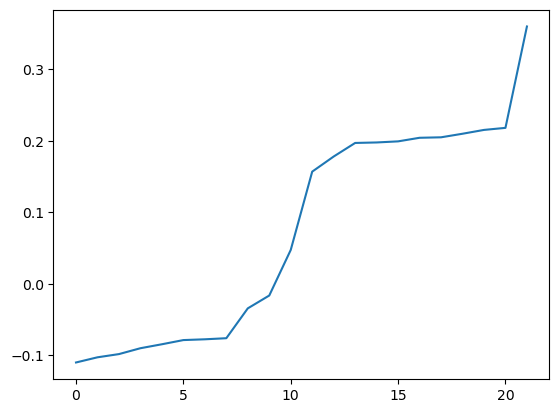

timestamp                  symbol
2022-09-23 06:00:00+00:00  ADA      -0.055556
                           ATOM     -0.055556
                           BTC       0.500000
                           DOT      -0.055556
                           ETC      -0.055556
                                       ...   
2022-11-22 06:00:00+00:00  ETH       0.039764
                           LINK     -0.201109
                           LTC      -0.069848
                           MATIC    -0.054184
                           XRP       0.003014
Name: position, Length: 14410, dtype: float32
['ADA', 'ATOM', 'BTC', 'DOT', 'ETC', 'ETH', 'LINK', 'LTC', 'MATIC', 'XRP']
test shift predict


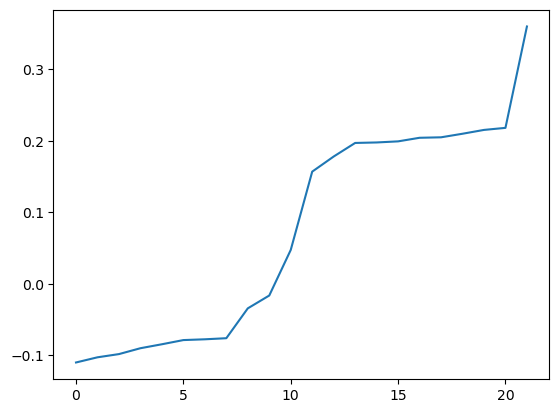

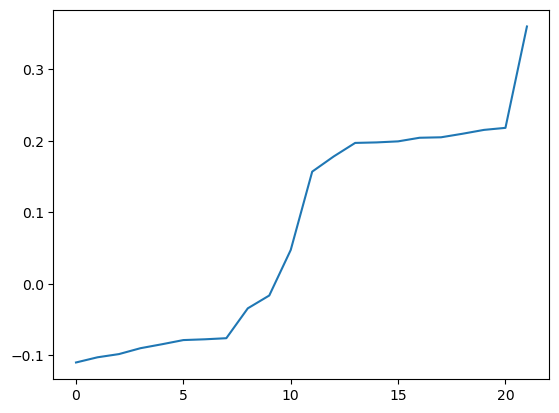

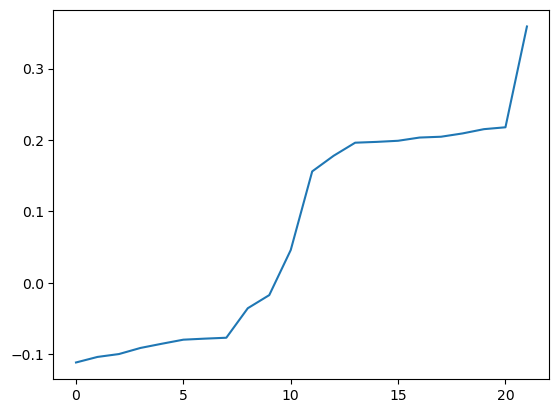

position1  position2  position3
timestamp                 symbol                                 
2022-09-23 07:00:00+00:00 ADA     -0.055556  -0.055556  -0.055556
                          ATOM    -0.055556  -0.055556  -0.055556
                          BTC      0.500000   0.500000   0.500000
                          DOT     -0.055556  -0.055556  -0.055556
                          ETC     -0.055556  -0.055556  -0.055556
...                                     ...        ...        ...
2022-11-22 05:00:00+00:00 ETH      0.109558   0.109558   0.109558
                          LINK     0.063517   0.063517   0.063517
                          LTC      0.056275   0.056275   0.056275
                          MATIC   -0.061092  -0.061092  -0.061092
                          XRP      0.155288   0.155288   0.155288

[14390 rows x 3 columns]

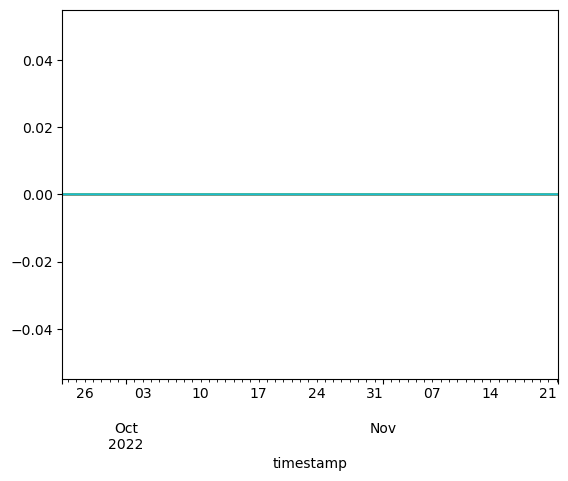

ADA (1439, 4)
ATOM (1439, 4)
BTC (1439, 4)
DOT (1439, 4)
ETC (1439, 4)
ETH (1439, 4)
LINK (1439, 4)
LTC (1439, 4)
MATIC (1439, 4)
XRP (1439, 4)


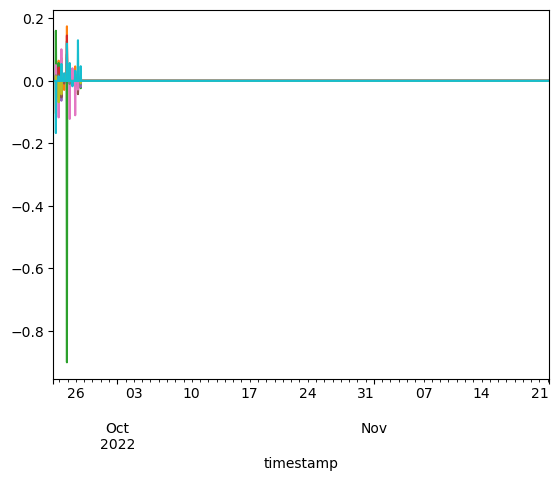

In [12]:
# model validation (Just run this cell in the new kernel to make sure you saved it in a portable format.)

import os
import joblib
import pandas as pd

model = joblib.load('/home/jovyan/data/{}.xz'.format(model_name))
df = pd.read_pickle('/tmp/df_binance_ohlcv_extended.pkl')
df = df[['op', 'hi', 'lo', 'cl', 'volume']]
max_timestamp = df.index.get_level_values('timestamp').max()
df = df.loc[max_timestamp - pd.to_timedelta(model.max_data_sec, unit='S') <= df.index.get_level_values('timestamp')]
print(model.predict(df))
print(model.symbols)



print('test shift predict')
import matplotlib.pyplot as plt

position1 = model.predict(df)
position2 = model.predict(df.loc[df.index.get_level_values('timestamp') < max_timestamp])
position3 = model.predict(df.loc[df.index.get_level_values('timestamp').min() < df.index.get_level_values('timestamp')])

test_timestamp = max_timestamp - pd.to_timedelta(1, unit='H')
df_test = pd.concat([
    position1.rename('position1'),
    position2.rename('position2'),
    position3.rename('position3'),
], axis=1)

df_test = df_test.dropna()
display(df_test)

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    (df_symbol['position2'] - df_symbol['position1']).plot()
plt.show()

for symbol, df_symbol in df_test.groupby('symbol'):
    df_symbol = df_symbol.reset_index().set_index('timestamp')
    print(symbol, df_symbol.shape)
    (df_symbol['position3'] - df_symbol['position1']).plot()
plt.show()